## Discovering Trends in Blockchain due to Covid-19

By: Nicholas Kuo

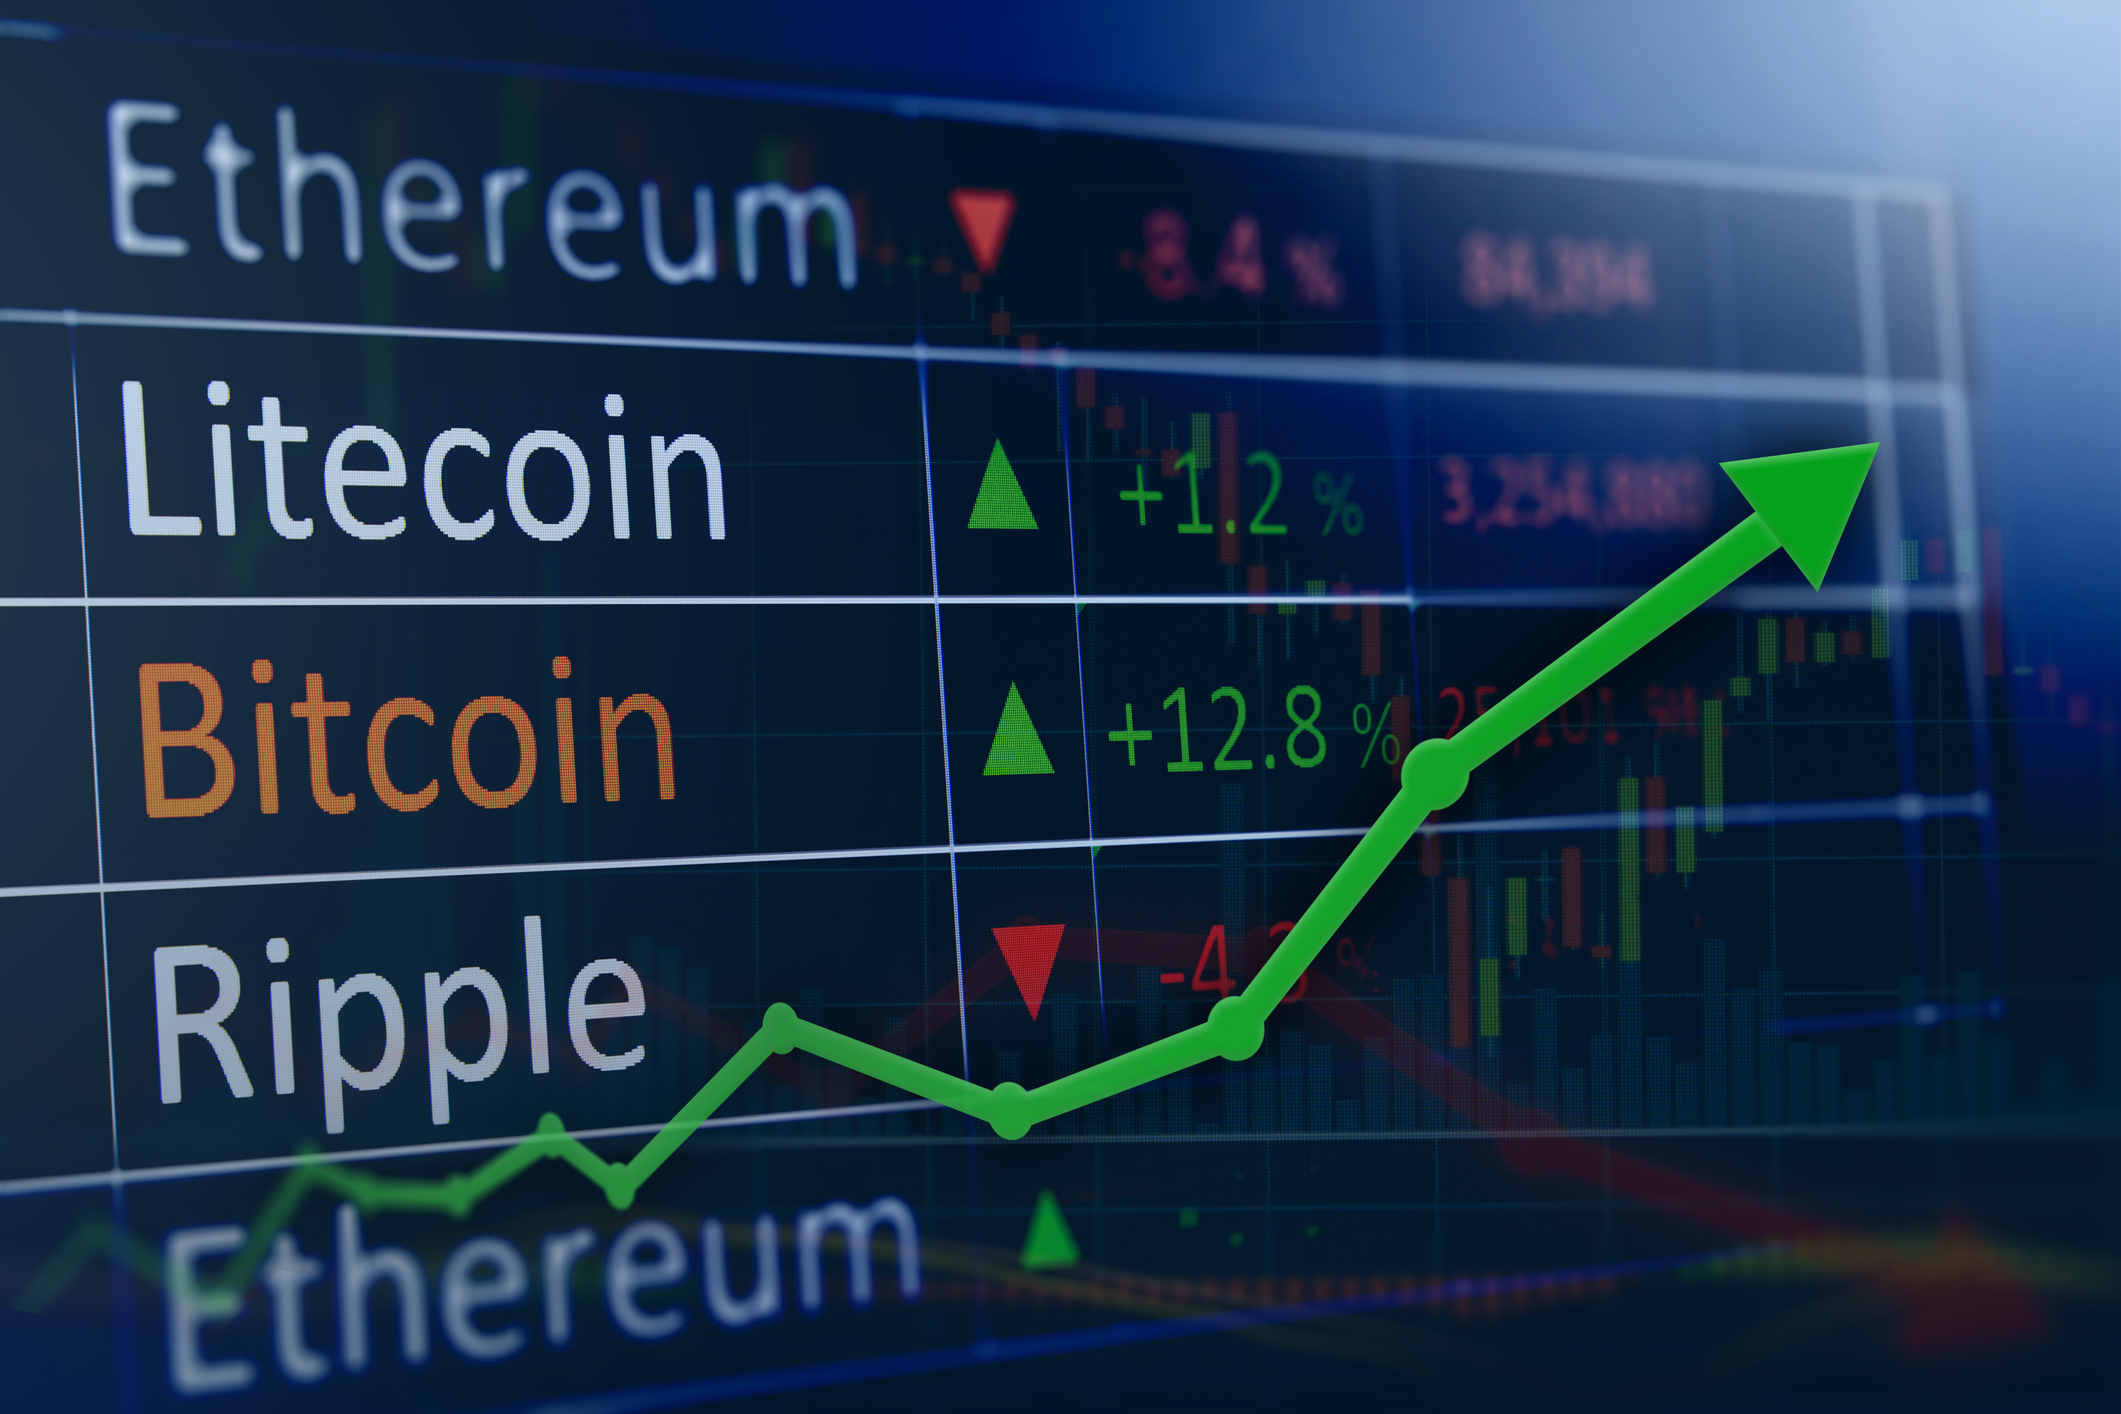

Welcome to our CIS 233 Final Homework 4! In this project, we focus our analysis on 5 popular currencies: Tether, Bitcoin, Ethereum, USD, Binance. 

Ever since Bitcoin was created in 2009, decentralized currencies have been increasingly become more and more popular. There are several reasons why having a decentralized currency would be beneficial, including not having to rely on untrustworthy or central parties and protecting customers from single points of failure such as bank crashes. However, despite its benefits there is a lot of skepticism surrounding decentralized currencies as they can be a very volatile investment, can be hard to understand, and Proof of Work-based blockchains use an extremely high amount of energy. The goal of this project to examine data surrounding different decentralized currencies, such as Bitcoin, Tether, and USDC, to better understand how these decentralized currencies fluctuate according to real world events such as civil unrest, Covid-19, and the news. 

The goal of this project is to learn about the overall impact of cryptocurrencies due to the real world, specifically in the lens of how real world events impact the sustainability of cryptocurrencies (in terms of popularity and the wealth inequality of crypto users). We will examine trends for these factors over time, especially due to the pandemic, when cryptocurrency usage rose significantly. 

By using visualization techniques such as time-series graphs, correlation matrices, and our final machine learning model that details wealth inequality, our team hopes to prove our hypothesis that blockchain currencies are sensitive to changes in the real world, where positive and negative events (like rising stocks, Covid-19, violence, etc) correlate to increases/decreases in cryptocurrencies' popularity and distribution of wealth.

# Setup, Parsing, Importing Data

We begin by importing and parsing our datasets in order to obtain the time series data on our 5 main currencies: Tether, Bitcoin, Ethereum, USD, and Binance. 

Our data comes from https://coinmetrics.io/community-network-data/

In [ ]:
import os
import json
import gzip
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from urllib.request import urlopen
import numpy as np
import math

In order to connect to and access our datasets, you need to be shared on our Google Drive Shared folder. In order to request access to the shared folder, please email nickkuo@seas.upenn.edu.

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/Shareddrives/CIS233/bnb.csv.zip
!unzip gdrive/Shareddrives/CIS233/btc.csv.zip
!unzip gdrive/Shareddrives/CIS233/eth.csv.zip
!unzip gdrive/Shareddrives/CIS233/usdc.csv.zip
!unzip gdrive/Shareddrives/CIS233/usdt.csv.zip

Archive:  gdrive/Shareddrives/CIS233/bnb.csv.zip
  inflating: bnb.csv                 
  inflating: __MACOSX/._bnb.csv      
Archive:  gdrive/Shareddrives/CIS233/btc.csv.zip
  inflating: btc.csv                 
  inflating: __MACOSX/._btc.csv      
Archive:  gdrive/Shareddrives/CIS233/eth.csv.zip
  inflating: eth.csv                 
  inflating: __MACOSX/._eth.csv      
Archive:  gdrive/Shareddrives/CIS233/usdc.csv.zip
  inflating: usdc.csv                
  inflating: __MACOSX/._usdc.csv     
Archive:  gdrive/Shareddrives/CIS233/usdt.csv.zip
  inflating: usdt.csv                
  inflating: __MACOSX/._usdt.csv     


In [ ]:
# https://coinmetrics.io/community-network-data/

# There are 122 columns (we can decide which ones are useful for us)
import pandas as pd
tether_df = pd.read_csv('usdt.csv')
bitcoin_df = pd.read_csv('btc.csv')
etherium_df = pd.read_csv('eth.csv')
usd_coin_df = pd.read_csv('usdc.csv')
binance_df = pd.read_csv('bnb.csv')

In [ ]:
tether_df = tether_df.add_suffix('_tether')
tether_df = tether_df.rename(columns={'time_tether': 'time'})

bitcoin_df = bitcoin_df.add_suffix('_bitcoin')
bitcoin_df = bitcoin_df.rename(columns={'time_bitcoin': 'time'})

etherium_df = etherium_df.add_suffix('_etherium')
etherium_df = etherium_df.rename(columns={'time_etherium': 'time'})

usd_coin_df = usd_coin_df.add_suffix('_usdCoin')
usd_coin_df = usd_coin_df.rename(columns={'time_usdCoin': 'time'})

binance_df = binance_df.add_suffix('_binance')
binance_df = binance_df.rename(columns={'time_binance': 'time'})

In [ ]:
combined_df = pd.merge(pd.merge(usd_coin_df, pd.merge(
    etherium_df,pd.merge(tether_df, bitcoin_df, how='outer', on=['time']), 
    how='outer', on=['time']), how='outer', on=['time']), binance_df, 
    how='outer', on=['time'])
combined_df = combined_df.sort_values(by='time', ascending=False)
combined_df = combined_df.dropna(how='all')
combined_df.head()
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4841 entries, 1341 to 3020
Columns: 610 entries, time to VtyDayRet30d_binance
dtypes: float64(609), object(1)
memory usage: 22.6+ MB


The first 5 datasets we import are from https://coinmetrics.io/community-network-data/. The next part uses web scraping in order to create a dataframe detailing the circulating supply, maximum supply, mining rate, transactions per second, etc of popular cryptocurrencies which include Bitcoin, Ether, Litecoin, EOS, and Stellar. 

In [ ]:
import requests
from lxml import html

# w = requests.get("https://www.fool.com/the-ascent/cryptocurrency/articles/68-of-the-biggest-cryptos-gained-1000-or-more-in-2021/")
w = requests.get("https://www.ig.com/en/cryptocurrency-trading/cryptocurrency-comparison/")
dom_tree = html.fromstring(w.content) 
print(dom_tree)

<Element html at 0x7f3df955da10>


In [ ]:
# /html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody
x_path_crypto_name = '/html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody/tr/td[1]/text()'
# x_path_crypto_name = '//div[@class="wysiwyg copy-body"]/div[3]/div/table/tbody/tr/td[2]/text()'

In [ ]:
crypto_columns = dom_tree.xpath(x_path_crypto_name)
for i in range(0, len(crypto_columns)):
    crypto_columns[i] = crypto_columns[i].strip()
crypto_columns.pop(0)
crypto_columns.insert(0, 'Crypto_Type')
crypto_columns.pop(6) #To get rid of (max)
crypto_columns

['Crypto_Type',
 'Launch',
 'Circulating supply',
 'Maximum supply',
 'Current mining/release rate',
 'Transactions per second',
 'Network',
 'Block time (approximate)']

In [ ]:
x_path_bitcoin = '/html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody/tr/td[2]/text()'
bitcoin_row = dom_tree.xpath(x_path_bitcoin)
for i in range(0, len(bitcoin_row)):
    bitcoin_row[i] = bitcoin_row[i].strip()
print(bitcoin_row)

x_path_etherium = '/html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody/tr/td[4]/text()'
etherium_row = dom_tree.xpath(x_path_etherium)
for i in range(0, len(etherium_row)):
    etherium_row[i] = etherium_row[i].strip()
print(etherium_row)

x_path_lightcoin = '/html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody/tr/td[5]/text()'
lightcoin_row = dom_tree.xpath(x_path_lightcoin)
for i in range(0, len(lightcoin_row)):
    lightcoin_row[i] = lightcoin_row[i].strip()
print(lightcoin_row)

x_path_eos = '/html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody/tr/td[6]/text()'
eos_row = dom_tree.xpath(x_path_eos)
for i in range(0, len(eos_row)):
    eos_row[i] = eos_row[i].strip()
print(eos_row)

x_path_stellar = '/html/body/div[2]/div/div/div/div[6]/div/div/div/div/div[1]/div/div/div/div[1]/div/div/div[2]/div/div/div/table/tbody/tr/td[7]/text()'
stellar_row = dom_tree.xpath(x_path_stellar)
for i in range(0, len(stellar_row)):
    stellar_row[i] = stellar_row[i].strip()
print(stellar_row)

['Bitcoin (BTC)', '2009', '>17 million', '21 million', '12.5 per block', '7', 'n/a', '10 minutes']
['Ether (ETH)', '2015', '>102 million', 'No upper limit', '3 per block', '20', 'Ethereum', '15 seconds']
['Litecoin (LTC)', '2011', '>58 million', '84 million', '25 per block', '56', 'n/a', '2 minutes 30 seconds']
['EOS (EOS)', '2018', '>906 million', 'No upper limit', 'Up to 5% inflation per year', '2800', 'EOS.IO', '0.5 seconds']
['Stellar (XLM)', '2014', '>18 billion', 'No upper limit', 'Up to 1% inflation per year', '1000', 'Stellar', '5 seconds']


In [ ]:
import pandas as pd
thisDict = {}
for col_index in range(len(crypto_columns)):
  thisDict[crypto_columns[col_index]] = [bitcoin_row[col_index], etherium_row[col_index], lightcoin_row[col_index],
                                         eos_row[col_index],stellar_row[col_index]]
crypto_comparisons = pd.DataFrame(thisDict)
crypto_comparisons['Circulating supply'] = crypto_comparisons['Circulating supply'].astype(str)
crypto_comparisons

,Crypto_Type,Launch,Circulating supply,Maximum supply,Current mining/release rate,Transactions per second,Network,Block time (approximate)
0,Bitcoin (BTC),2009,>17 million,21 million,12.5 per block,7,n/a,10 minutes
1,Ether (ETH),2015,>102 million,No upper limit,3 per block,20,Ethereum,15 seconds
2,Litecoin (LTC),2011,>58 million,84 million,25 per block,56,n/a,2 minutes 30 seconds
3,EOS (EOS),2018,>906 million,No upper limit,Up to 5% inflation per year,2800,EOS.IO,0.5 seconds
4,Stellar (XLM),2014,>18 billion,No upper limit,Up to 1% inflation per year,1000,Stellar,5 seconds


As most of our analysis analyzes the future sustainability (popularity and distribution of wealth) of major cryptocurrencies, the above table aids in providing important context behind major cryptocurrencies. As shown from the comparison chart above, each cryptocurrency has drastically different protocols and work extremely differently in terms of currency supply, mining rate, and block time. After understanding these discrepencies, we will now demonstrate how each cryptocurrency responds differently to major real-world events (like Covid and capitol riots). 

We hope you find our visualizations and explanations of changing trends in cryptocurrencies' popularity and wealth inequality interesting!

Our main 2 hypothesis are 1) popularity of each cryptocurrency will be very sensitive to real-world events like Covid-19 and 2) wealth inequality will continue to drastically grow in most cryptocurrencies over time.

## Data Cleaning/Wrangling

Below we drop rows with null entries. We also display the dataframes of the 5 main dataframes we will be conducting data analysis on.

In [ ]:
# Drops rows that don't have any data
tether_df = tether_df.dropna()
bitcoin_df = bitcoin_df.dropna()
etherium_df = etherium_df.dropna()
usd_coin_df = usd_coin_df.dropna()
binance_df = binance_df.dropna()

In [ ]:
tether_df

,time,AdrActCnt_tether,AdrBal1in100KCnt_tether,AdrBal1in100MCnt_tether,AdrBal1in10BCnt_tether,AdrBal1in10KCnt_tether,AdrBal1in10MCnt_tether,AdrBal1in1BCnt_tether,AdrBal1in1KCnt_tether,AdrBal1in1MCnt_tether,...,TxTfrCnt_tether,TxTfrValAdjNtv_tether,TxTfrValAdjUSD_tether,TxTfrValMeanNtv_tether,TxTfrValMeanUSD_tether,TxTfrValMedNtv_tether,TxTfrValMedUSD_tether,VelCur1yr_tether,VtyDayRet180d_tether,VtyDayRet30d_tether
646,2015-10-06,23.0,67.0,295.0,327.0,29.0,195.0,311.0,15.0,146.0,...,39.0,5.264726e+04,5.028310e+04,1352.679661,1291.936893,34.850000,33.285043,16.945301,0.038489,0.011708
647,2015-10-07,25.0,73.0,302.0,334.0,31.0,202.0,318.0,14.0,152.0,...,44.0,7.881209e+03,7.506470e+03,236.169962,224.940444,32.989750,31.421138,16.968300,0.037594,0.011434
648,2015-10-08,20.0,68.0,300.0,332.0,29.0,199.0,316.0,14.0,149.0,...,27.0,1.233870e+03,1.220567e+03,46.143333,45.645840,25.650000,25.373455,16.971059,0.037682,0.013303
649,2015-10-09,16.0,66.0,299.0,331.0,28.0,197.0,315.0,14.0,146.0,...,18.0,5.751583e+04,5.575070e+04,3198.101537,3099.953446,42.850000,41.534956,17.098523,0.037700,0.013862
650,2015-10-10,8.0,66.0,299.0,331.0,28.0,197.0,315.0,14.0,146.0,...,10.0,1.283394e+05,1.229938e+05,12833.936996,12299.382620,97.488887,93.428316,17.382696,0.036924,0.014007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,2022-03-31,190.0,1922.0,146705.0,212870.0,339.0,52377.0,182671.0,50.0,10969.0,...,194.0,1.649885e+06,1.650410e+06,8939.446641,8942.290257,104.845000,104.878351,4.231765,0.000180,0.000117
3015,2022-04-01,106.0,1923.0,146728.0,212896.0,341.0,52398.0,182695.0,50.0,10977.0,...,93.0,3.215633e+06,3.216743e+06,35988.045927,36000.468639,916.978851,917.295383,4.179010,0.000180,0.000117
3016,2022-04-02,60.0,1924.0,146733.0,212903.0,340.0,52402.0,182701.0,50.0,10978.0,...,52.0,1.630063e+06,1.630674e+06,45413.573282,45430.591958,1828.317941,1829.003100,4.136399,0.000179,0.000109
3017,2022-04-03,85.0,1922.0,146744.0,212918.0,339.0,52414.0,182715.0,50.0,10982.0,...,79.0,6.007841e+05,6.009702e+05,7713.755668,7716.145670,363.000000,363.112471,4.091127,0.000179,0.000109


In [ ]:
bitcoin_df

,time,AdrActCnt_bitcoin,AdrBal1in100KCnt_bitcoin,AdrBal1in100MCnt_bitcoin,AdrBal1in10BCnt_bitcoin,AdrBal1in10KCnt_bitcoin,AdrBal1in10MCnt_bitcoin,AdrBal1in1BCnt_bitcoin,AdrBal1in1KCnt_bitcoin,AdrBal1in1MCnt_bitcoin,...,TxTfrCnt_bitcoin,TxTfrValAdjNtv_bitcoin,TxTfrValAdjUSD_bitcoin,TxTfrValMeanNtv_bitcoin,TxTfrValMeanUSD_bitcoin,TxTfrValMedNtv_bitcoin,TxTfrValMedUSD_bitcoin,VelCur1yr_bitcoin,VtyDayRet180d_bitcoin,VtyDayRet30d_bitcoin
2409,2015-08-09,262571.0,9252.0,711943.0,2403998.0,887.0,294373.0,1422379.0,67.0,101875.0,...,276720.0,702282.628908,1.870474e+08,4.201519,1119.041171,0.005625,1.498290,20.710122,0.025668,0.024495
2410,2015-08-10,292834.0,9266.0,711729.0,2402893.0,888.0,294527.0,1421750.0,66.0,102000.0,...,304538.0,282564.753846,7.485955e+07,3.463212,917.504698,0.022000,5.828434,20.755157,0.025667,0.023780
2411,2015-08-11,271613.0,9272.0,712733.0,2405978.0,885.0,294968.0,1424671.0,66.0,102037.0,...,280398.0,333270.418453,9.045684e+07,3.785274,1027.405708,0.049104,13.327852,20.790885,0.025707,0.021451
2412,2015-08-12,278802.0,9262.0,714517.0,2410983.0,882.0,295531.0,1426195.0,66.0,102177.0,...,293592.0,452620.208124,1.213673e+08,4.168242,1117.688449,0.037566,10.073023,20.825459,0.025332,0.018550
2413,2015-08-13,272849.0,9278.0,714951.0,2413080.0,885.0,295750.0,1426996.0,66.0,102161.0,...,280693.0,406369.804072,1.075627e+08,4.446716,1177.008494,0.038885,10.292443,20.864479,0.024544,0.018460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,2022-03-31,979952.0,9396.0,2335886.0,16865231.0,973.0,476302.0,7225672.0,44.0,98832.0,...,853649.0,459325.922195,2.092790e+10,1.128283,51407.056424,0.002392,108.972050,15.517104,0.033572,0.032976
4836,2022-04-01,1073859.0,9399.0,2337982.0,16882029.0,976.0,476529.0,7235576.0,44.0,98823.0,...,909511.0,529181.954067,2.447484e+10,1.134783,52484.082723,0.002365,109.376495,15.541297,0.033585,0.033029
4837,2022-04-02,932911.0,9400.0,2339849.0,16886022.0,975.0,477003.0,7237409.0,44.0,98810.0,...,791162.0,237565.437581,1.091373e+10,0.735145,33772.500192,0.002054,94.356415,15.544044,0.033546,0.032363
4838,2022-04-03,794992.0,9386.0,2341449.0,16898014.0,975.0,477503.0,7241397.0,44.0,98791.0,...,709127.0,209590.141361,9.733480e+09,0.610715,28361.954795,0.001910,88.701439,15.547817,0.033384,0.028047


In [ ]:
etherium_df

,time,AdrActCnt_etherium,AdrBal1in100KCnt_etherium,AdrBal1in100MCnt_etherium,AdrBal1in10BCnt_etherium,AdrBal1in10KCnt_etherium,AdrBal1in10MCnt_etherium,AdrBal1in1BCnt_etherium,AdrBal1in1KCnt_etherium,AdrBal1in1MCnt_etherium,...,TxTfrCnt_etherium,TxTfrValAdjNtv_etherium,TxTfrValAdjUSD_etherium,TxTfrValMeanNtv_etherium,TxTfrValMeanUSD_etherium,TxTfrValMedNtv_etherium,TxTfrValMedUSD_etherium,VelCur1yr_etherium,VtyDayRet180d_etherium,VtyDayRet30d_etherium
374,2016-08-07,20085.0,5715.0,63586.0,142351.0,1119.0,34264.0,89763.0,112.0,15656.0,...,51113.0,1.975374e+06,2.177514e+07,62.183892,685.471741,1.001421,11.038961,7.024621,0.084586,0.091806
375,2016-08-08,20439.0,5738.0,63125.0,142645.0,1118.0,34108.0,89944.0,111.0,15683.0,...,75328.0,1.996075e+06,2.257538e+07,39.049717,441.647804,0.147550,1.668772,7.043333,0.084186,0.091690
376,2016-08-09,22799.0,5761.0,63473.0,143324.0,1132.0,34243.0,89909.0,108.0,15757.0,...,55293.0,3.565106e+06,4.387603e+07,100.900193,1241.786121,1.003216,12.346657,7.087723,0.081587,0.092947
377,2016-08-10,21183.0,5817.0,63917.0,143945.0,1146.0,34615.0,90336.0,112.0,15933.0,...,52842.0,4.543117e+06,5.494717e+07,132.054508,1597.146110,1.003051,12.131497,7.151241,0.081409,0.092723
378,2016-08-11,22502.0,5842.0,63406.0,144707.0,1163.0,34451.0,90800.0,113.0,15977.0,...,55715.0,3.588709e+06,4.200713e+07,105.464380,1234.498595,1.001092,11.718140,7.210277,0.081366,0.092968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,2022-03-31,588466.0,5504.0,1209766.0,20773087.0,1038.0,245442.0,5966639.0,120.0,36475.0,...,949655.0,2.615690e+06,8.584139e+09,3.649993,11978.502974,0.080000,262.543001,14.621032,0.039125,0.032171
2437,2022-04-01,565448.0,5507.0,1211110.0,20796685.0,1036.0,245473.0,5970072.0,120.0,36474.0,...,947283.0,2.283146e+06,7.868907e+09,3.079442,10613.358899,0.098750,340.343834,14.601765,0.039292,0.033182
2438,2022-04-02,540620.0,5511.0,1212713.0,20820014.0,1037.0,245506.0,5978192.0,119.0,36469.0,...,946755.0,1.570187e+06,5.420231e+09,2.048133,7070.085543,0.081597,281.671055,14.522577,0.039287,0.032049
2439,2022-04-03,533295.0,5516.0,1213999.0,20835649.0,1036.0,245540.0,5986302.0,119.0,36465.0,...,1030407.0,1.116917e+06,3.933259e+09,1.430046,5035.954895,0.079787,280.971919,14.458554,0.039217,0.027590


In [ ]:
usd_coin_df

,time,AdrActCnt_usdCoin,AdrBal1in100KCnt_usdCoin,AdrBal1in100MCnt_usdCoin,AdrBal1in10BCnt_usdCoin,AdrBal1in10KCnt_usdCoin,AdrBal1in10MCnt_usdCoin,AdrBal1in1BCnt_usdCoin,AdrBal1in1KCnt_usdCoin,AdrBal1in1MCnt_usdCoin,...,TxTfrCnt_usdCoin,TxTfrValAdjNtv_usdCoin,TxTfrValAdjUSD_usdCoin,TxTfrValMeanNtv_usdCoin,TxTfrValMeanUSD_usdCoin,TxTfrValMedNtv_usdCoin,TxTfrValMedUSD_usdCoin,VelCur1yr_usdCoin,VtyDayRet180d_usdCoin,VtyDayRet30d_usdCoin
421,2019-09-28,1450.0,1508.0,21323.0,50080.0,512.0,8336.0,38638.0,111.0,3533.0,...,2055.0,3.074462e+07,3.074738e+07,22472.972239,22474.993957,412.005401,412.042466,42.244012,0.000959,0.000485
422,2019-09-29,1431.0,1521.0,21388.0,50197.0,518.0,8382.0,38722.0,115.0,3567.0,...,2058.0,5.815824e+07,5.815607e+07,36840.060725,36838.689915,315.841652,315.829900,42.403307,0.000958,0.000482
423,2019-09-30,2005.0,1533.0,21436.0,50357.0,519.0,8447.0,38834.0,113.0,3612.0,...,3019.0,3.810040e+07,3.809880e+07,17849.715565,17848.962463,502.682339,502.661130,42.408141,0.000956,0.000440
424,2019-10-01,2225.0,1565.0,21557.0,50560.0,522.0,8525.0,39001.0,111.0,3659.0,...,3792.0,4.430957e+07,4.431840e+07,19276.868461,19280.710977,392.218521,392.296703,42.742638,0.000941,0.000443
425,2019-10-02,2048.0,1539.0,21082.0,50430.0,495.0,8242.0,38703.0,109.0,3602.0,...,3406.0,9.418539e+07,9.421737e+07,41476.384430,41490.463146,434.775000,434.922580,40.291574,0.000940,0.000435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,2022-03-31,30522.0,5532.0,200508.0,782452.0,752.0,75120.0,560841.0,93.0,26419.0,...,61077.0,5.853553e+09,5.852954e+09,138790.524763,138776.323595,3292.428861,3292.091977,53.080597,0.000217,0.000148
1337,2022-04-01,31207.0,5502.0,199679.0,783085.0,745.0,74858.0,560739.0,93.0,26259.0,...,63956.0,5.476225e+09,5.476107e+09,129404.774633,129401.974105,3340.544015,3340.471720,53.017999,0.000217,0.000134
1338,2022-04-02,25953.0,5486.0,198243.0,782294.0,748.0,74650.0,560063.0,92.0,26229.0,...,54234.0,3.288748e+09,3.288604e+09,88382.662554,88378.783375,3121.940000,3121.802976,53.073304,0.000215,0.000133
1339,2022-04-03,21796.0,5498.0,197408.0,782230.0,748.0,74466.0,559698.0,93.0,26120.0,...,45483.0,2.218221e+09,2.218178e+09,69306.465168,69305.122189,2773.917840,2773.864089,53.051853,0.000214,0.000133


In [ ]:
binance_df

,time,AdrActCnt_binance,AdrBal1in100KCnt_binance,AdrBal1in100MCnt_binance,AdrBal1in10BCnt_binance,AdrBal1in10KCnt_binance,AdrBal1in10MCnt_binance,AdrBal1in1BCnt_binance,AdrBal1in1KCnt_binance,AdrBal1in1MCnt_binance,...,TxTfrCnt_binance,TxTfrValAdjNtv_binance,TxTfrValAdjUSD_binance,TxTfrValMeanNtv_binance,TxTfrValMeanUSD_binance,TxTfrValMedNtv_binance,TxTfrValMedUSD_binance,VelCur1yr_binance,VtyDayRet180d_binance,VtyDayRet30d_binance
375,2018-07-15,206.0,384.0,18753.0,300801.0,78.0,8872.0,56662.0,13.0,2273.0,...,255.0,6.208593e+04,7.621209e+05,268.710800,3298.495137,17.527194,215.150874,1.141308,0.067240,0.037991
376,2018-07-16,250.0,387.0,18831.0,300895.0,78.0,8910.0,56758.0,13.0,2277.0,...,334.0,8.918336e+04,1.179838e+06,290.658365,3845.222438,35.201229,465.689523,1.140233,0.067429,0.039770
377,2018-07-17,329.0,387.0,18906.0,300992.0,76.0,8934.0,56854.0,13.0,2283.0,...,390.0,1.712262e+05,2.347960e+06,577.773821,7922.794795,29.861624,409.481206,1.138289,0.067483,0.039326
378,2018-07-18,386.0,385.0,19005.0,301095.0,76.0,9045.0,56960.0,13.0,2288.0,...,437.0,5.728534e+06,7.363665e+07,13174.001066,169343.392471,29.861624,383.852158,1.181333,0.067564,0.040284
379,2018-07-19,307.0,388.0,19059.0,301180.0,75.0,9064.0,57046.0,13.0,2288.0,...,410.0,1.139185e+05,1.466790e+06,438.402723,5644.777450,32.296559,415.843421,1.176906,0.067269,0.040317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,2019-04-18,2753.0,430.0,21996.0,314920.0,91.0,8520.0,69490.0,19.0,2816.0,...,4612.0,1.391525e+06,3.056857e+07,421.625706,9262.135501,10.788933,237.007752,1.902335,0.053604,0.046426
653,2019-04-19,3902.0,424.0,21836.0,315111.0,89.0,8316.0,69684.0,19.0,2710.0,...,6060.0,1.687270e+06,4.104426e+07,339.869918,8267.622041,10.000000,243.258423,1.912541,0.054090,0.048869
654,2019-04-20,3612.0,401.0,21643.0,314680.0,88.0,7983.0,69296.0,20.0,2553.0,...,5333.0,1.373388e+06,3.424443e+07,332.832023,8298.923782,10.000000,249.342707,1.920066,0.054107,0.047092
655,2019-04-21,2991.0,382.0,21523.0,314592.0,86.0,7863.0,69197.0,19.0,2490.0,...,4743.0,1.516630e+06,3.669906e+07,406.091202,9826.503842,11.915219,288.321795,1.928726,0.054171,0.047336


## Exploratory Data Analysis

For Tether, Bitcoin, Ethereum, USD, and Binance, we will conduct 3 main visualizations. We will first visualize how the number of daily transfers of each currency changes over time, from their inception to more recent dates. In this visualization, we will also perform smoothing and data interpolation across months (instead of days). Hence, for each major currency, we will be displaying time series graphs with 2 lines: one blue line for the daily amount of transfers and another orange line for a smoothed, data interpolated average amount of transfers over each month. We create this smoothing and data interpolation in order to see general trends over time rather than focus on the rapid up and down spikes of daily transactions. 

Our second visualization is regarding how fees for Bitcoin and Etherium (the only currencies out of our selection that have fees) change over time. We will see how each of these currencies have rapidly changing fees over time.

Our last visualization is regarding the wealth inequality present on each of these currencies. We visualize wealth inequality by graphing a time series graph which transposes the amount of individuals in the following demographics: users with more than \$1 k - \$10 k USD in the given cryptocurrency; users with more than \$10 k - \$100 k USD in the given cryptocurrency; users with more than \$100 k - \$1 M USD in the given cryptocurrency; users with more than \$1M- \$10M USD in the given cryptocurrency.

In [ ]:
# Plotting how count of transfers change over the years for each major currency
tether_txn = tether_df[['time', 'TxTfrCnt_tether']]
tether_txn = tether_txn.rename(columns={'time':'Dates', 'TxTfrCnt_tether': 'Number of Transfers'})

In [ ]:
bitcoin_txn = bitcoin_df[['time', 'TxTfrCnt_bitcoin']]
bitcoin_txn = bitcoin_txn.rename(columns={'time':'Dates', 'TxTfrCnt_bitcoin': 'Number of Transfers'})

In [ ]:
etherium_txn = etherium_df[['time', 'TxTfrCnt_etherium']]
etherium_txn = etherium_txn.rename(columns={'time':'Dates', 'TxTfrCnt_etherium': 'Number of Transfers'})

In [ ]:
usd_txn = usd_coin_df[['time', 'TxTfrCnt_usdCoin']]
usd_txn = usd_txn.rename(columns={'time':'Dates', 'TxTfrCnt_usdCoin': 'Number of Transfers'})

In [ ]:
binance_txn = binance_df[['time', 'TxTfrCnt_binance']]
binance_txn = binance_txn.rename(columns={'time':'Dates', 'TxTfrCnt_binance': 'Number of Transfers'})

In [ ]:
tether_txn['Interpolation - Number of Transfers'] = tether_txn['Number of Transfers'].rolling(30).mean()
tether_txn1 = tether_txn.melt('Dates', var_name='Legend', value_name='Number Transfers')

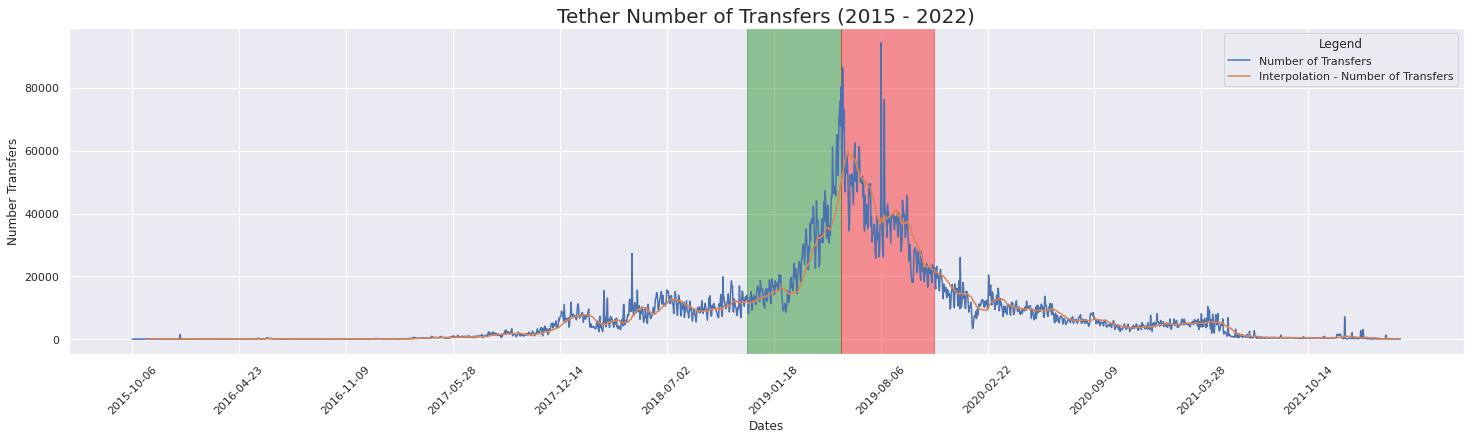

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

sns.set(font_scale = 1)
plt.figure(figsize=(25,6))

line_plot = sns.lineplot(x='Dates', y='Number Transfers', hue='Legend', data=tether_txn1, ci=None)
line_plot.set_title('Tether Number of Transfers (2015 - 2022)', fontsize=20)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200])
for item in line_plot.get_xticklabels():
    item.set_rotation(45)

plt.axvspan(1150, 1325, color='green', alpha=0.4)
plt.axvspan(1325, 1500, color='red', alpha=0.4)
plt.show()

We will analyze 2 major trends in the popularity of Tether. The growth of Tether's usage from January 2019 to May 2019, as well as the decline of Tether's usage form May 2019 to January 2020. 

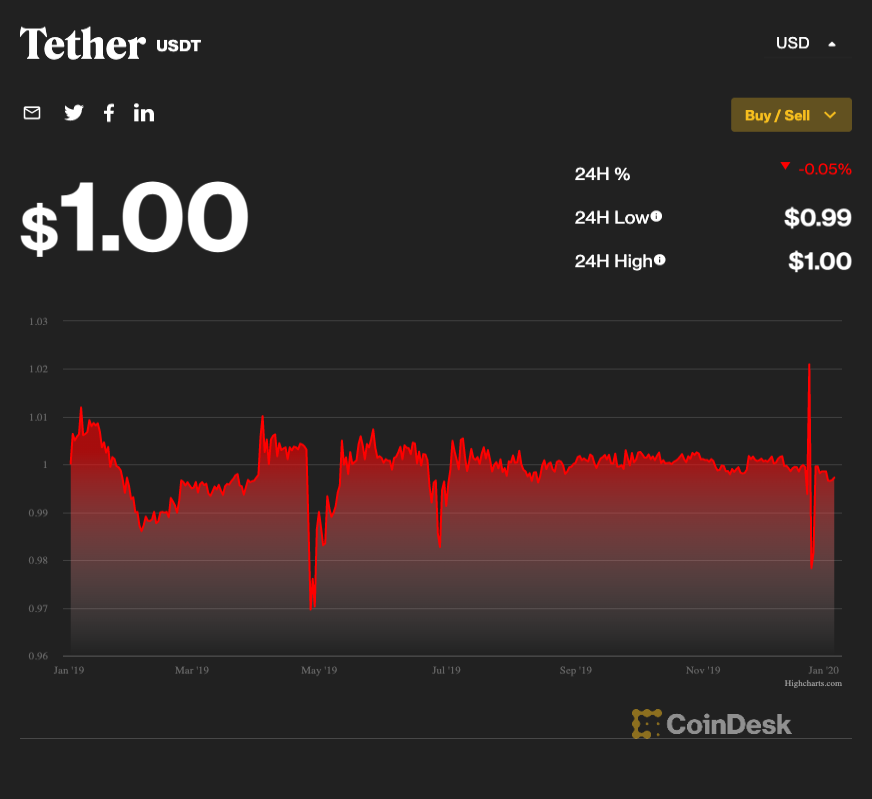

[This chart from CoinDesk](https://www.coindesk.com/price/tether/) displays the value of USDT during the 2019 calendar year. We can see that in the middle of the period that Tether increased a sharp increase in number of transfers, from January to May, its value dipped below 99 cents. During this time, in February, Tether updated its website to say: “Every tether is always 100% backed by our reserves, which include traditional currency and cash equivalents and, from time to time, may include other assets and receivables from loans made by Tether to third parties, which may include affiliated entities (collectively, ‘reserves’).” However, this statement caused some suspicion, leading to an investigation to be opened up by the NY Attorney General. In April of 2019, right before the value of Tether went into stee decline, [AG Letitia James announced](https://ag.ny.gov/press-release/2019/attorney-general-james-announces-court-order-against-crypto-currency-company) that the invesigation found Tether and Bitfinex operators were"engaged in a cover-up to hide the apparent loss of $850 million dollars of co-mingled client and corporate funds."

In [ ]:
bitcoin_txn['Interpolation - Number of Transfers'] = bitcoin_txn['Number of Transfers'].rolling(30).mean()
bitcoin_txn1 = bitcoin_txn.melt('Dates', var_name='Legend', value_name='Number Transfers')

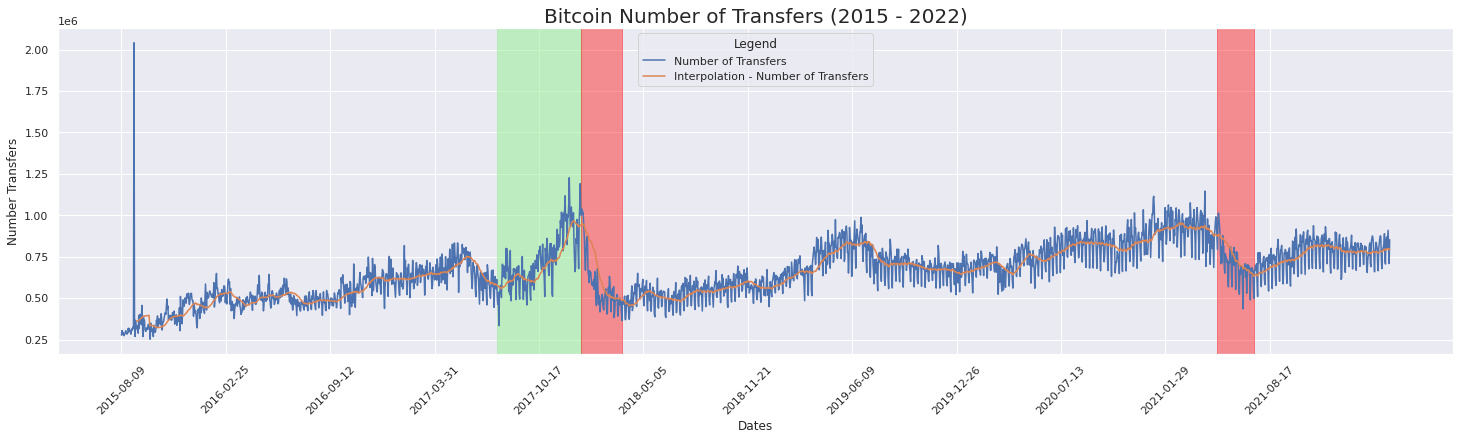

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='Dates', y='Number Transfers', hue='Legend', data=bitcoin_txn1, ci=None)
line_plot.set_title('Bitcoin Number of Transfers (2015 - 2022)', fontsize=20)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200])
for item in line_plot.get_xticklabels():
    item.set_rotation(45)

plt.axvspan(720, 880, color='lightgreen', alpha=0.5)
plt.axvspan(880, 960, color='red', alpha=0.4)
plt.axvspan(2100, 2170, color='red', alpha=0.4)
plt.show()

Now, we'll investigate trends in the number of Bitcoin transfers over time. This figure clearly shows the high volatility in Bitcoin activity. 

In [ ]:
etherium_txn['Interpolation - Number of Transfers'] = etherium_txn['Number of Transfers'].rolling(30).mean()
etherium_txn1 = etherium_txn.melt('Dates', var_name='Legend', value_name='Number Transfers')

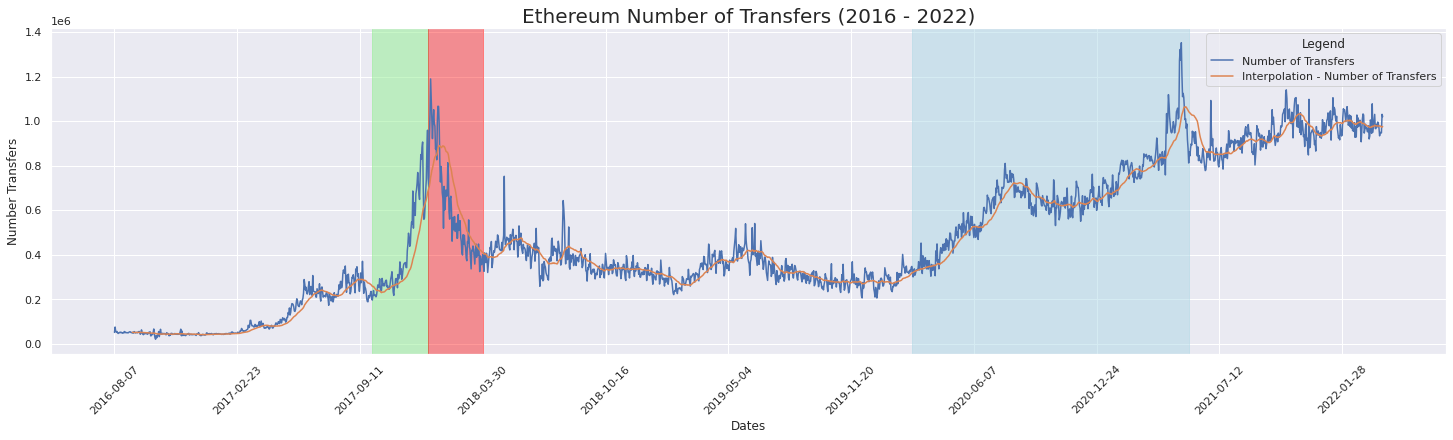

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='Dates', y='Number Transfers', hue='Legend', data=etherium_txn1, ci=None)
line_plot.set_title('Ethereum Number of Transfers (2016 - 2022)', fontsize=20)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200])
for item in line_plot.get_xticklabels():
    item.set_rotation(45)

plt.axvspan(420, 510, color='lightgreen', alpha=0.5)
plt.axvspan(510, 600, color='red', alpha=0.4)
plt.axvspan(1300, 1750, color='lightblue', alpha=0.5)
plt.show()

Next, we'll investigate fluctuations in the Ethereum's number of transfer since its creation in 2016. Particularly, we'll examine its increase in activity from November in 2017 to around January of 2018 and its decrease in acitivity from January to March of 2018. We'll also look at the behavior of Ethereum transfers during the onset of the pandemic starting in March 2020.  

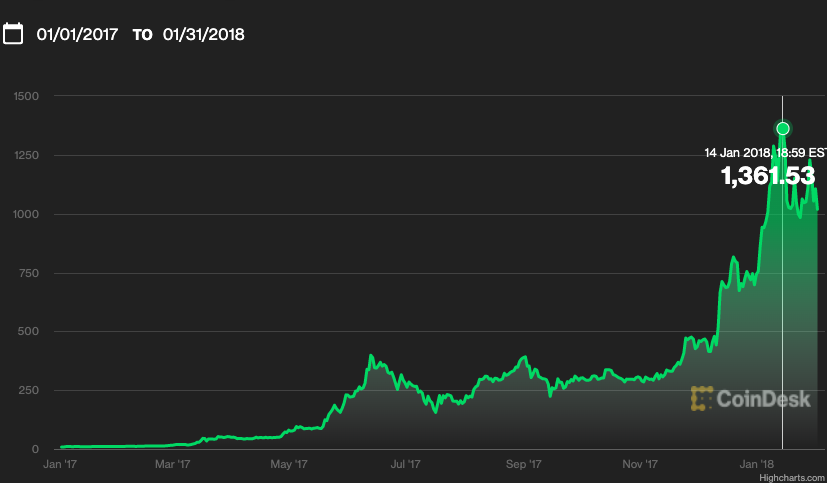

As shown in [the figure above](https://www.coindesk.com/price/ethereum/), after a slow and steady climb, Ethereum saw its first big spike in value in the spring of 2017. By mid-June it was at 343.42 USD, and by January 2018 the value reached a high of over 1300 USD[(1)](https://fortune.com/2021/04/29/ethereum-price-how-much-would-it-be-worth-now-historical-value-eth-usd-investment-bitcoin-dogecoin/). However, due to the high volatility of ETH and all other cryptocurencies during this time, by April of 2018 the value had dipped to $379. Therefore, while ETH did experience a large surge during 2017, the volatility of the cryptocurrency landscape at the time resulted in a large amount of doubt and uncertainty for its value. As a result, after its initial rise in value, the Ethereum transfer activity remained quite stagnant until the end 2019.

Luckily for Ethereum and othe cryptocurrencies, the onset of the COVID-19 pandemic meant that the number of activity among decentralized currencies and applications skyrocketed. For example, the market value for NFTs [rose exponentially during the pandemic](https://www.wfmz.com/news/pr_newswire/pr_newswire_technology/the-nft-as-a-consequence-of-covid-19-is-it-a-new-digital-virus/article_57654e5c-52ce-51f4-94c4-875bc4332b20.html); it tripled in 2020 and then doubled again within the first quarter of 2021. This timeframe clearly coincides with the upward trend in Ethereum transactions during the time period highlighted in blue, which makes sense as Ethereum is the leading blockchain to buy and sell NFTs with. 

Other than the rise of NFTs, there are a multitude of other factors that attribute to Ethereum's large growth during the pandemic. This period of uncertainty resulted in a lot of movement within financial markets, making cryptocurrencies seem more desirable. Interoperable DeFi protocols allowed users to quickly move assets and interact across platforms, and an increasing number of users moved towards DEXs like Uniswap and Kyber, moving into safe haven assets like stablecoins.


In [ ]:
usd_txn['Interpolation - Number of Transfers'] = usd_txn['Number of Transfers'].rolling(30).mean()
usd_txn1 = usd_txn.melt('Dates', var_name='Legend', value_name='Number Transfers')

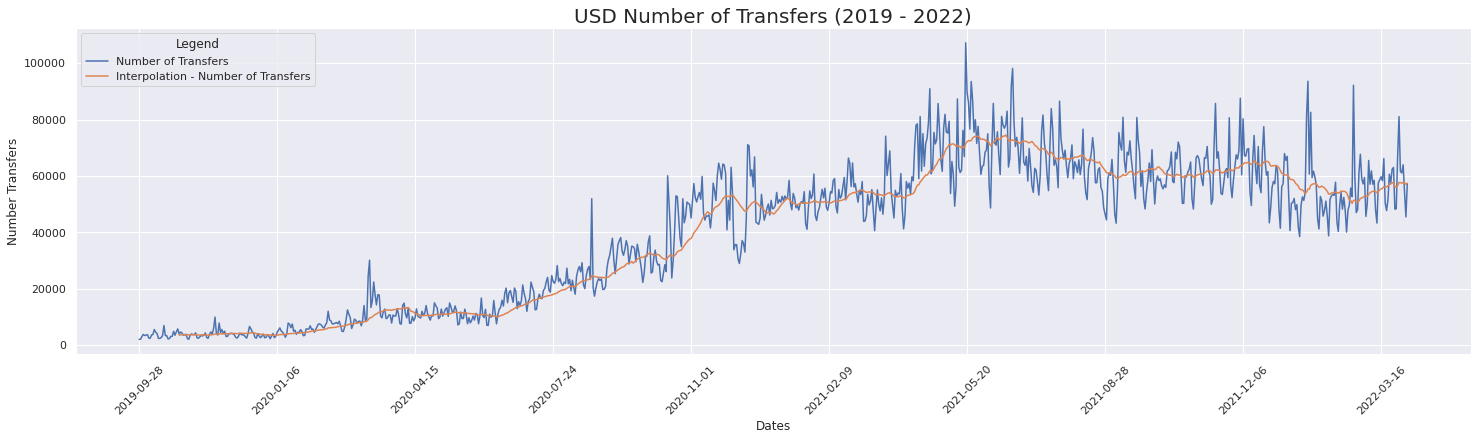

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='Dates', y='Number Transfers', hue='Legend', data=usd_txn1, ci=None)
line_plot.set_title('USD Number of Transfers (2019 - 2022)', fontsize=20)
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
for item in line_plot.get_xticklabels():
    item.set_rotation(45)

Looking at the number of USDC transfers over time, we can see that it has been steadily increasing ever since 2019. While the month to month activity can vary significantly, our interpolation shows that over longer periods of time, this activity has been climbing at a pretty steady rate. Other than the increasing popularity of stable coins within the cryptocurrency market, a notable factor that likely contributed to its growth starting in the middle of 2020 is the rise of dApps. This is because any dApp built on the Ethereum chain can be used with USDC, making it a popular choice for users.

In [ ]:
binance_txn['Interpolation - Number of Transfers'] = binance_txn['Number of Transfers'].rolling(30).mean()
binance_txn1 = usd_txn.melt('Dates', var_name='Legend', value_name='Number Transfers')

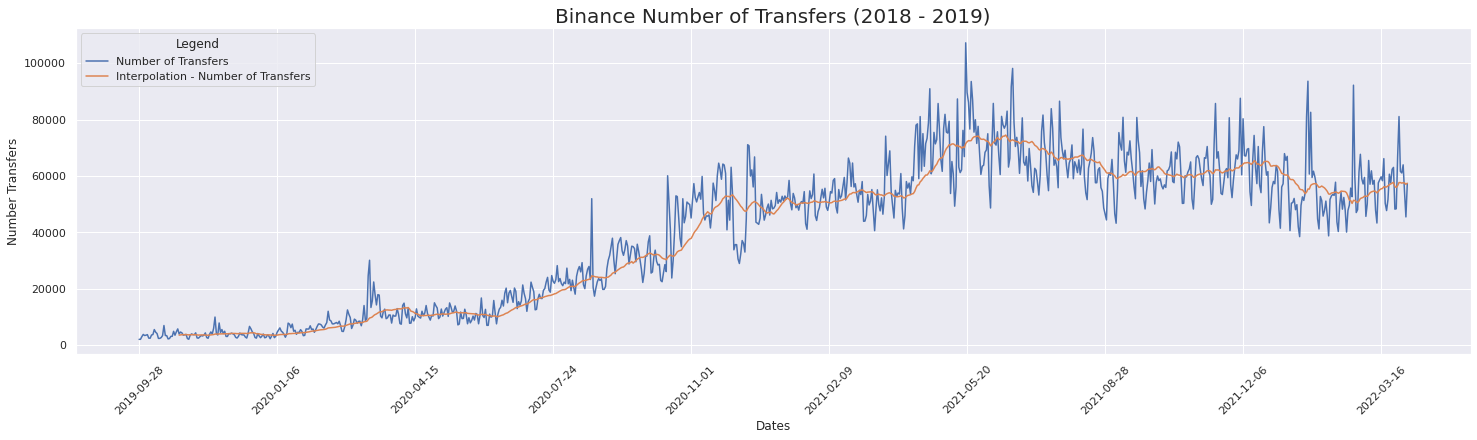

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='Dates', y='Number Transfers', hue='Legend', data=binance_txn1, ci=None)
line_plot.set_title('Binance Number of Transfers (2018 - 2019)', fontsize=20)
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
for item in line_plot.get_xticklabels():
    item.set_rotation(45)

Fees for Bitcoin and Ethereum Over Time

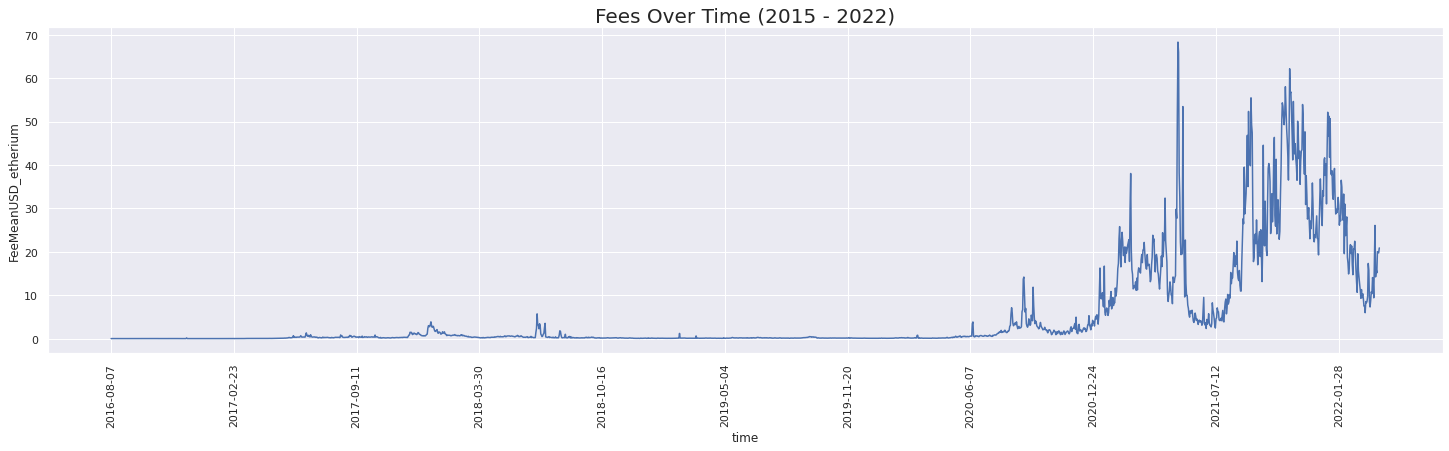

In [ ]:
#Etherium
am = etherium_df[['time', 'FeeMeanUSD_etherium']]
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='time', y='FeeMeanUSD_etherium', data=am, ci=None, palette = 'flare_r')
line_plot.set_title('Fees Over Time (2015 - 2022)', fontsize=20)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, ])
for item in line_plot.get_xticklabels():
    item.set_rotation(90)

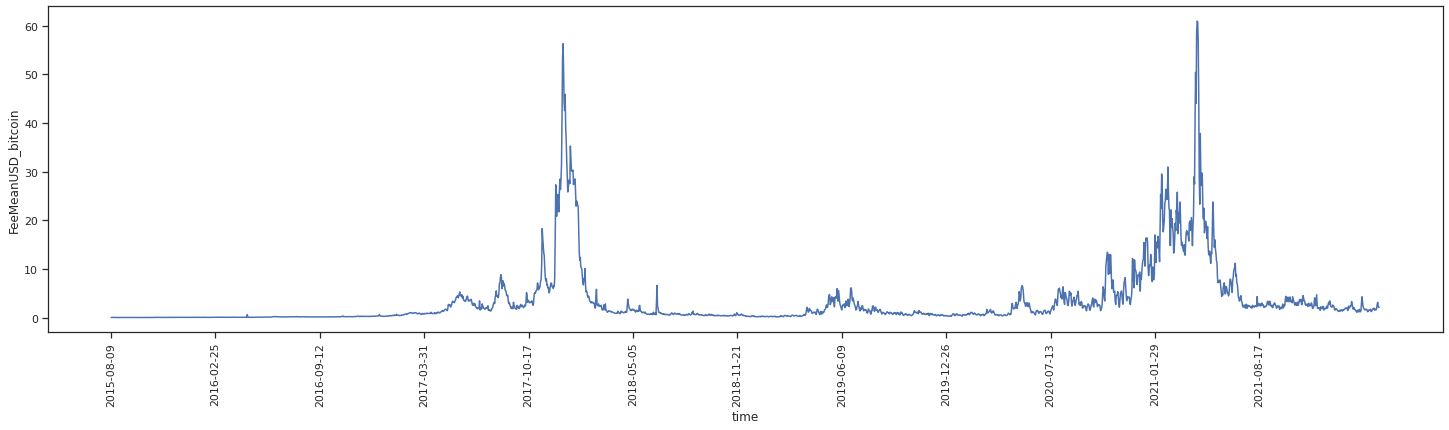

In [ ]:
# Bitcoin
sns.set_theme(style="ticks")
data = bitcoin_df[['time', 'FeeMeanUSD_bitcoin']]

palette = sns.color_palette("rocket_r")
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(
    data=data, x="time", y="FeeMeanUSD_bitcoin", palette=palette,
)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200])
for item in line_plot.get_xticklabels():
    item.set_rotation(90)

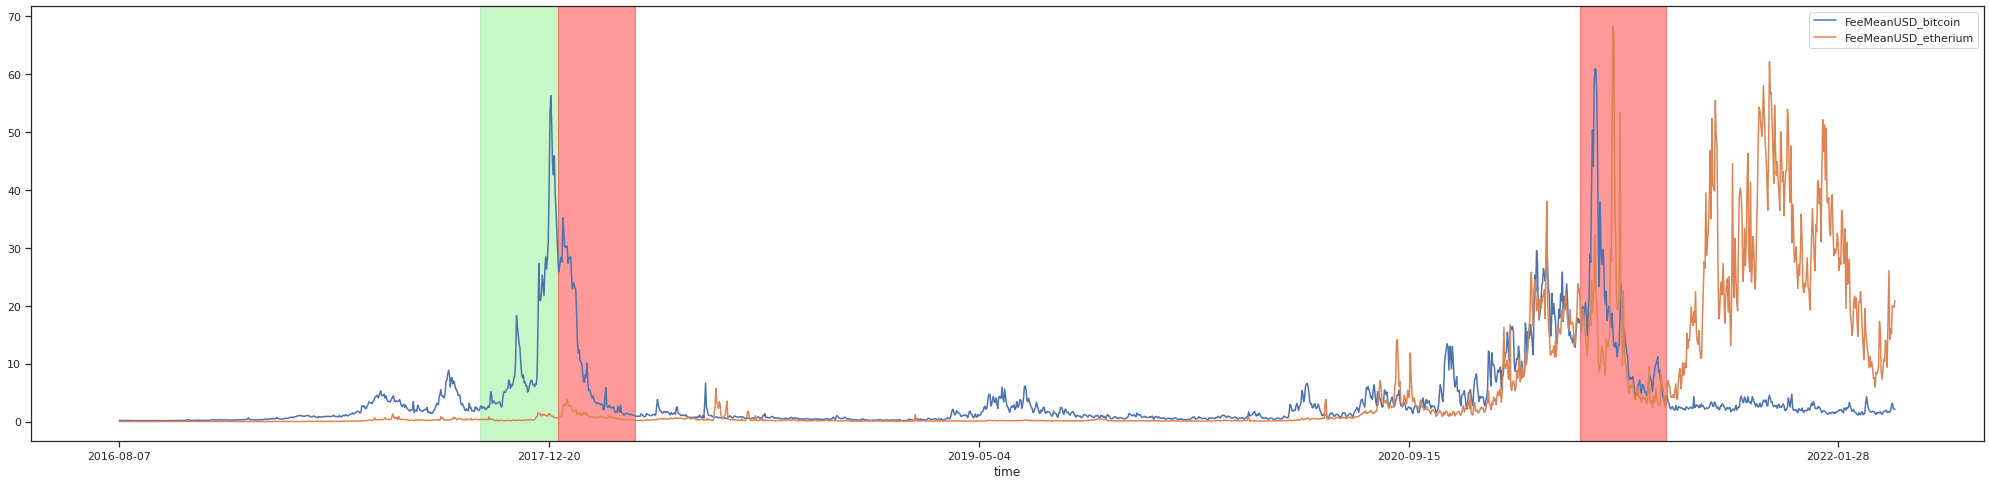

In [ ]:
bitcoin_fees = bitcoin_df[['time','FeeMeanUSD_bitcoin']]
etherium_fees = etherium_df[['time','FeeMeanUSD_etherium']]
be_fees = pd.merge(left=bitcoin_fees, right=etherium_fees, left_on='time', right_on='time')

be_fees.plot(x='time', y=['FeeMeanUSD_bitcoin', 'FeeMeanUSD_etherium'], figsize=(35,8))
plt.axvspan(420, 510, color='lightgreen', alpha=0.5)
plt.axvspan(510, 600, color='red', alpha=0.4)
plt.axvspan(1700, 1800, color='red', alpha=0.4)

**Wealth Distribution**

Now, we will examine the wealth distributions of Bitcoin and Ethereum. Our data contained information regarding the number of users with more than 1, 10, up to 10M USD in their accounts. We used this information to find the number of users at each wealth level, where each level is a power of 10 USD. For example, to find the number of addresses that had over one thousand dollars and less than ten thousand dollars, we subtracted the number of addresses with over 10k from the number of addresses with over 1k. In the following figures, whenever we indicate the number of addresses at a certain wealth level, we mean that is the number of addresses with at least that amount but less than the next wealth level. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

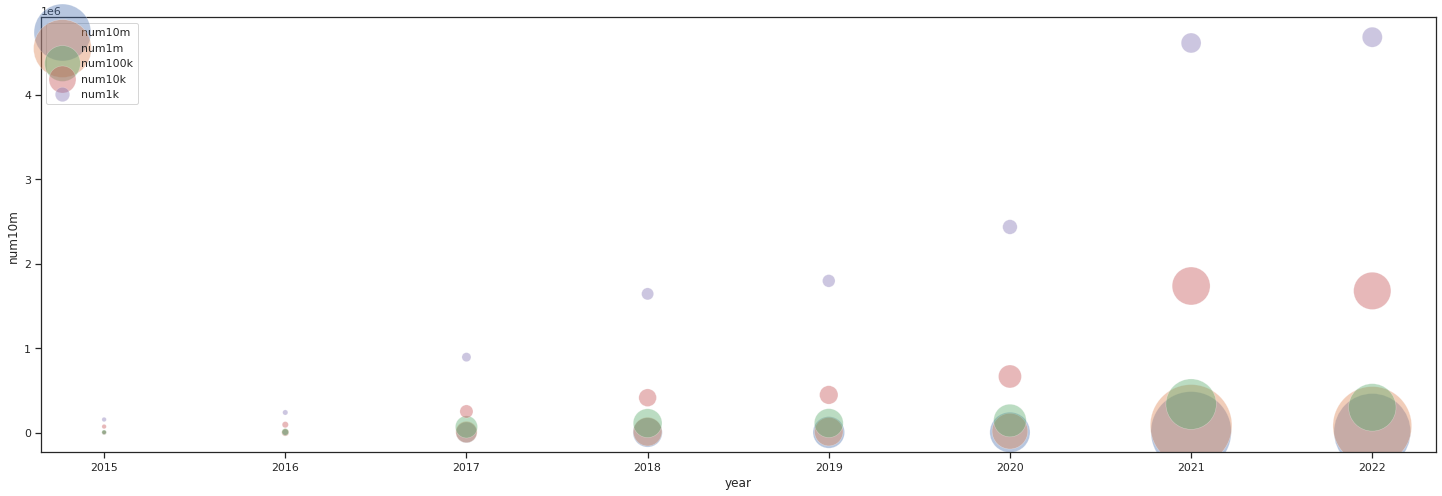

In [ ]:
#BITCOIN WEALTH DISTRIBUTION PLOTT

# Extracting Appropriate Columns
btc_wealth_df = bitcoin_df[['time', 'AdrBalUSD1Cnt_bitcoin', 'AdrBalUSD10Cnt_bitcoin', 'AdrBalUSD100Cnt_bitcoin', 'AdrBalUSD1KCnt_bitcoin', 'AdrBalUSD10KCnt_bitcoin', 'AdrBalUSD100KCnt_bitcoin','AdrBalUSD1MCnt_bitcoin', 'AdrBalUSD10MCnt_bitcoin']]

# Calcululating Number of Users
btc_wealth_df['num10m'] = btc_wealth_df['AdrBalUSD10MCnt_bitcoin']
btc_wealth_df['num1m'] = btc_wealth_df['AdrBalUSD1MCnt_bitcoin'] - btc_wealth_df['num10m']
btc_wealth_df['num100k'] = btc_wealth_df['AdrBalUSD100KCnt_bitcoin'] - btc_wealth_df['num1m']
btc_wealth_df['num10k'] = btc_wealth_df['AdrBalUSD10KCnt_bitcoin'] - btc_wealth_df['num100k']
btc_wealth_df['num1k'] = btc_wealth_df['AdrBalUSD1KCnt_bitcoin'] - btc_wealth_df['num10k']

btc_wealth_df['10msum'] = (btc_wealth_df['num10m'] * 10000000)
btc_wealth_df['1msum'] = (btc_wealth_df['num1m'] * 1000000)
btc_wealth_df['100ksum'] = (btc_wealth_df['num100k'] * 100000)
btc_wealth_df['10ksum'] = (btc_wealth_df['num10k'] * 10000)
btc_wealth_df['1ksum'] = (btc_wealth_df['num1k'] * 1000)


btc_wealth_df['year'] = btc_wealth_df.loc[:, ('time')].str[:4]
btc_wealth_df = btc_wealth_df.dropna()
avg_btc_wealth = btc_wealth_df.groupby(['year']).mean()

plt.figure(figsize=(25,8))

sns.scatterplot(data=avg_btc_wealth, x="year", y="num10m", size="10msum", legend=False, sizes=(20, 6452), alpha  = 0.4)
sns.scatterplot(data=avg_btc_wealth, x="year", y="num1m", size="1msum", legend=False, sizes=(20, 6658), alpha  = 0.4)
sns.scatterplot(data=avg_btc_wealth, x="year", y="num100k", size="100ksum", legend=False, sizes=(20, 2538), alpha  = 0.4)
sns.scatterplot(data=avg_btc_wealth, x="year", y="num10k", size="10ksum", legend=False, sizes=(20, 1436), alpha  = 0.4)
sns.scatterplot(data=avg_btc_wealth, x="year", y="num1k", size="1ksum", legend=False, sizes=(20, 400), alpha  = 0.4)
plt.legend(labels=['num10m', 'num1m', 'num100k', 'num10k', 'num1k'])



*   The figure above displays the number of account that are at a given wealth level in a particular year, where the larger buble shows a higher total wealth shared between all of the accounts at that spot
*   We can clearly note the increase in extrememly wealthy accounts and we can also note the vast number of poorer accounts growing in the market



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

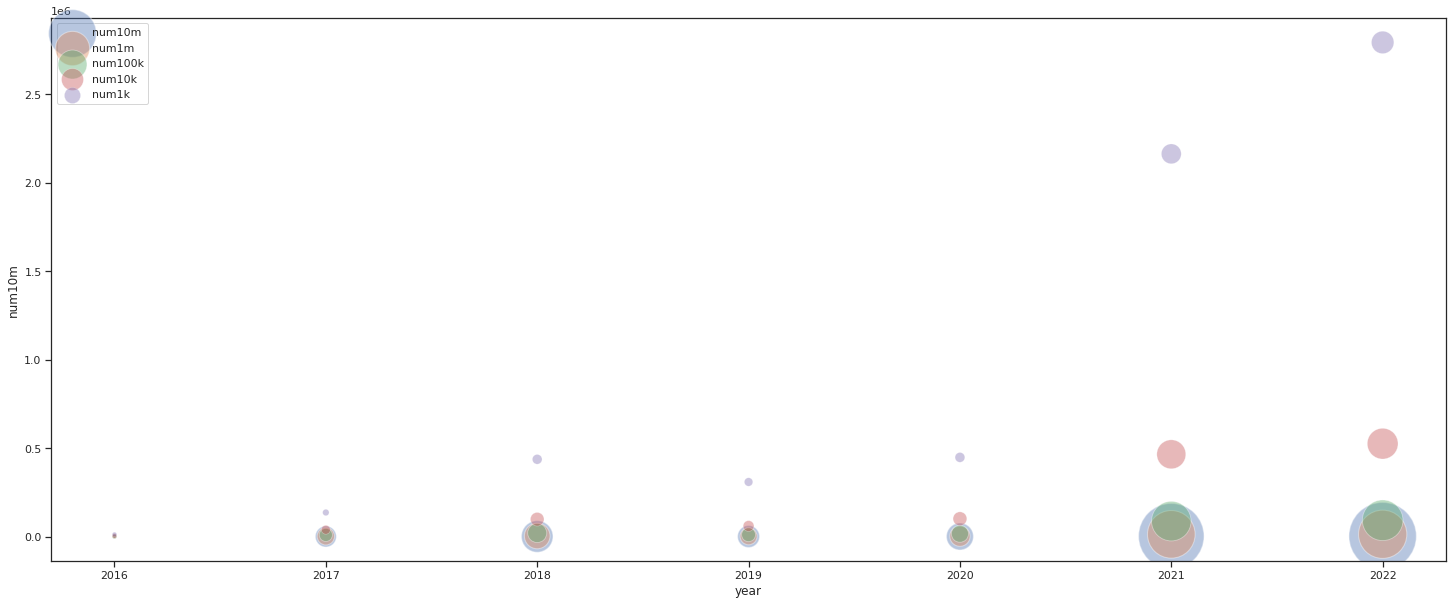

In [ ]:
#ETHEREUM WEALTH

# Extracting Appropriate Columns
eth_wealth_df = etherium_df[['time', 'AdrBalUSD1Cnt_etherium', 'AdrBalUSD10Cnt_etherium', 'AdrBalUSD100Cnt_etherium', 'AdrBalUSD1KCnt_etherium', 'AdrBalUSD10KCnt_etherium', 'AdrBalUSD100KCnt_etherium','AdrBalUSD1MCnt_etherium', 'AdrBalUSD10MCnt_etherium']]

# Calcululating Number of Users
eth_wealth_df['num10m'] = eth_wealth_df['AdrBalUSD10MCnt_etherium']
eth_wealth_df['num1m'] = eth_wealth_df['AdrBalUSD1MCnt_etherium'] - eth_wealth_df['num10m']
eth_wealth_df['num100k'] = eth_wealth_df['AdrBalUSD100KCnt_etherium'] - eth_wealth_df['num1m']
eth_wealth_df['num10k'] = eth_wealth_df['AdrBalUSD10KCnt_etherium'] - eth_wealth_df['num100k']
eth_wealth_df['num1k'] = eth_wealth_df['AdrBalUSD1KCnt_etherium'] - eth_wealth_df['num10k']

eth_wealth_df['10msum'] = (eth_wealth_df['num10m'] * 10000000)
eth_wealth_df['1msum'] = (eth_wealth_df['num1m'] * 1000000)
eth_wealth_df['100ksum'] = (eth_wealth_df['num100k'] * 100000)
eth_wealth_df['10ksum'] = (eth_wealth_df['num10k'] * 10000)
eth_wealth_df['1ksum'] = (eth_wealth_df['num1k'] * 1000)


eth_wealth_df['year'] = eth_wealth_df.loc[:, ('time')].str[:4]
eth_wealth_df = eth_wealth_df.dropna()
eth_avg = eth_wealth_df.groupby(['year']).mean()

plt.figure(figsize=(25,10))
sns.scatterplot(data=eth_avg, x="year", y="num10m", size="10msum", legend=False, sizes=(20, 4551), alpha  = 0.4, palette='bright')
sns.scatterplot(data=eth_avg, x="year", y="num1m", size="1msum", legend=False, sizes=(20, 2329), alpha  = 0.4)
sns.scatterplot(data=eth_avg, x="year", y="num100k", size="100ksum", legend=False, sizes=(20, 1650), alpha  = 0.4)
sns.scatterplot(data=eth_avg, x="year", y="num10k", size="10ksum", legend=False, sizes=(20, 941), alpha  = 0.4)
sns.scatterplot(data=eth_avg, x="year", y="num1k", size="1ksum", legend=False, sizes=(20, 500), alpha  = 0.4)
plt.legend(labels=['num10m', 'num1m', 'num100k', 'num10k', 'num1k'])

:The above figures depict the number of accounts at each wealth level every year. The size of the circle indicates the total wealth owned by all accounts at that level. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


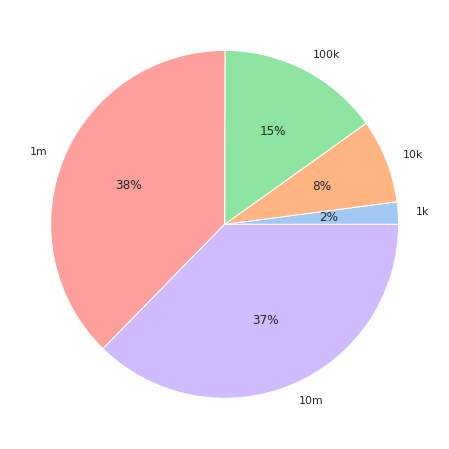

In [ ]:
# #Portion of Money Owned by Wealth Level for Bitcoin in 2021
colors = sns.color_palette('pastel')[0:8]
btc_last2 = avg_btc_wealth.tail(2)
btc_2021 = btc_last2.head(1)
btc_wealth_portion = btc_2021[['1ksum', '10ksum', '100ksum', '1msum',	'10msum']]
plt.figure(figsize=(8,8))
btc_wealth = plt.pie(btc_wealth_portion, colors = colors, autopct='%.0f%%', labels=['1k', '10k', '100k', '1m', '10m'])

The figure above displays a proportionate relationship between the wealth level (money that a specific PK has in a wallet) and the amount of market room that it takes up when considering how much of Bitcoin (approx. 18 million) is available in the market

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  import sys


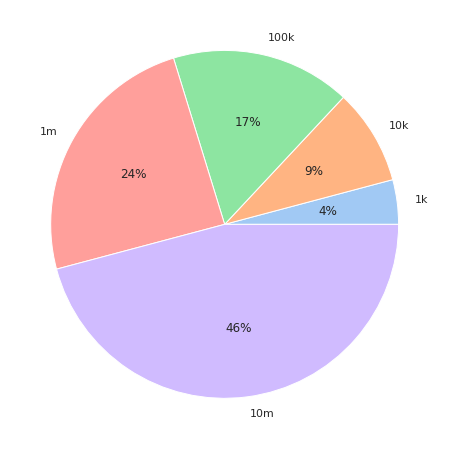

In [ ]:
#Portion of Money Owned by Wealth Level for Ethereum in 2021
colors = sns.color_palette('pastel')[0:8]
eth_last2 = eth_avg.tail(2)
eth_2021= eth_last2.head(1)
plt.figure(figsize=(8,8))
eth_wealth_portion = eth_2021[['1ksum', '10ksum', '100ksum', '1msum',	'10msum']]
etc_wealth = plt.pie(eth_wealth_portion, colors = colors, autopct='%.0f%%', labels=['1k', '10k', '100k', '1m', '10m'])

Note the increase of extrememly wealthy Ethereum accounts in comparison to Bitocin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


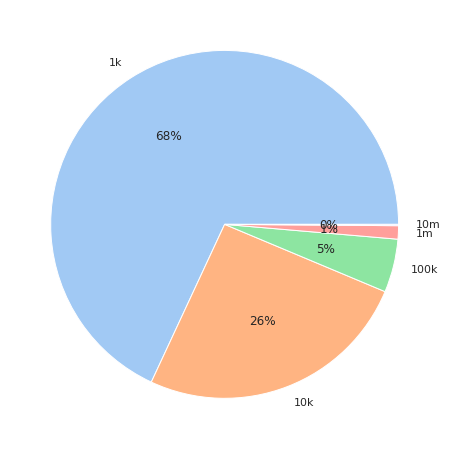

In [ ]:
#Portion of Number Accounts by Wealth Level for Bitcoin in 2021
colors = sns.color_palette('pastel')[0:8]
last2 = avg_btc_wealth.tail(2)
last_year = last2.head(1)
wealth_df = last_year[['num1k', 'num10k', 'num100k', 'num1m',	'num10m']]

plt.figure(figsize=(8,8))
plt.pie(wealth_df, colors = colors, autopct='%.0f%%', labels=['1k', '10k', '100k', '1m', '10m'])
plt.show()

This pie chart in comparison to the ones above serves to display the number of accounts that are active in a given wealth range. There is a great majority that are under 1K, and we can see a very tiny proportion that is holding a third of the wealth in the market (as shown by the above graph)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


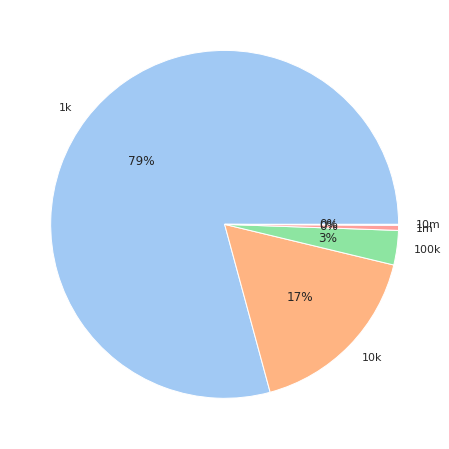

In [ ]:
#Portion of Number Accounts by Wealth Level for Ethereum in 2021
colors = sns.color_palette('pastel')[0:8]
last2 = eth_avg.tail(2)
last_year = last2.head(1)
wealth_df = last_year[['num1k', 'num10k', 'num100k', 'num1m',	'num10m']]

plt.figure(figsize=(8,8))
plt.pie(wealth_df, colors = colors, autopct='%.0f%%', labels=['1k', '10k', '100k', '1m', '10m'])
plt.show()

At an even higher rate than that of bitcoin, Ethereum has many accounts with a small amount of the Wealth (we can assume that a good portion of these are through NFT's and other popular smart contracts)

Based off of the pie charts, it's clear that both Etherium and Bitcoin have large wealth gaps, with less than 1% of accounts for each blockchain controling over 70% of the wealth. However, while the majority of the wealth is split evenly between addresses with 1M USD and addresses with 10M USD for Bitcoin, accounts with over 10M USD have nearly double the wealth that accounts with <10M and >1M have. 

Text(0, 0.5, 'Total Money Owned')

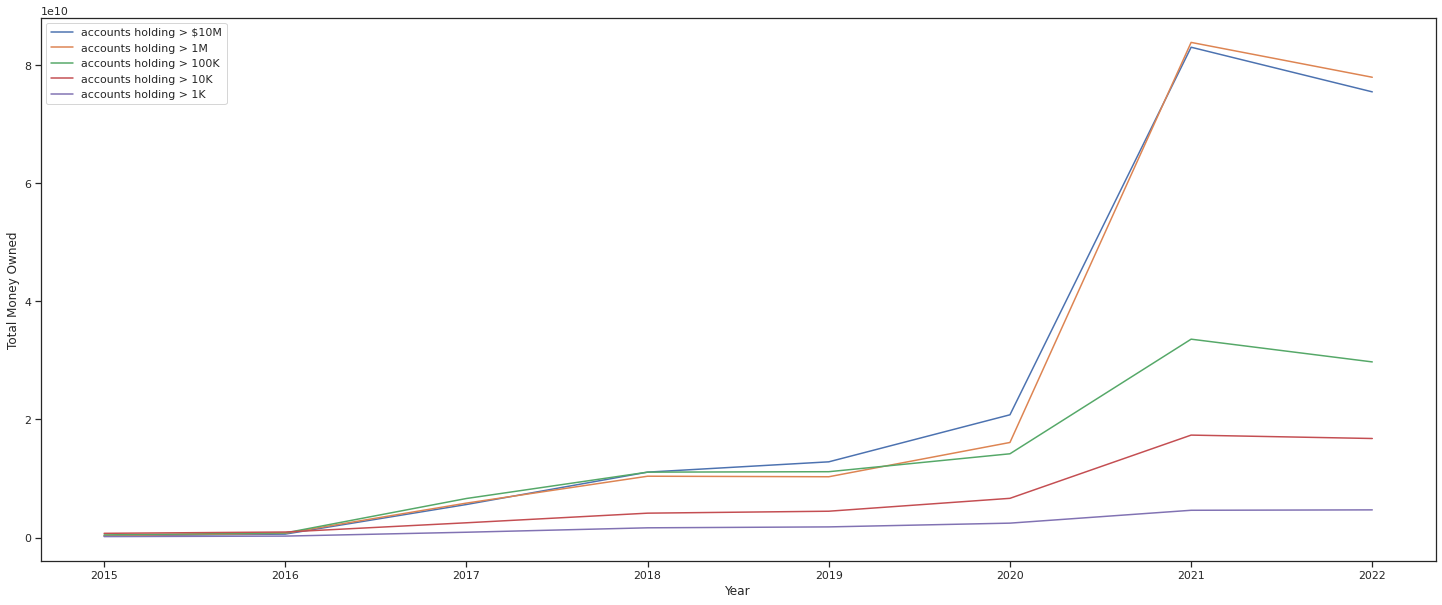

In [ ]:
# Amount Owned By Addresses At Each Wealth Level in Bitcoin Over Time
plt.figure(figsize=(25,10))
line_plot = sns.lineplot(x='year', y='10msum', data=btc_wealth_df, ci=None, palette = 'bright', label="accounts holding > $10M")
line_plot = sns.lineplot(x='year', y='1msum', data=btc_wealth_df, ci=None, palette = 'bright', label="accounts holding > 1M")
line_plot = sns.lineplot(x='year', y='100ksum', data=btc_wealth_df, ci=None, palette = 'bright', label='accounts holding > 100K')
line_plot = sns.lineplot(x='year', y='10ksum', data=btc_wealth_df, ci=None, palette = 'bright', label='accounts holding > 10K')
line_plot = sns.lineplot(x='year', y='1ksum', data=btc_wealth_df, ci=None, palette = 'bright', label='accounts holding > 1K')
plt.xlabel("Year")
plt.ylabel("Total Money Owned")

We can clearly see that beginning in 2016 and being extended in the pandamic, the wealthy accounts holding a majority of the cryptocurrency have been growing as massive rates when compared to the relatively stagnent growth of the lower accounts.

Text(0, 0.5, 'Total Money Owned')

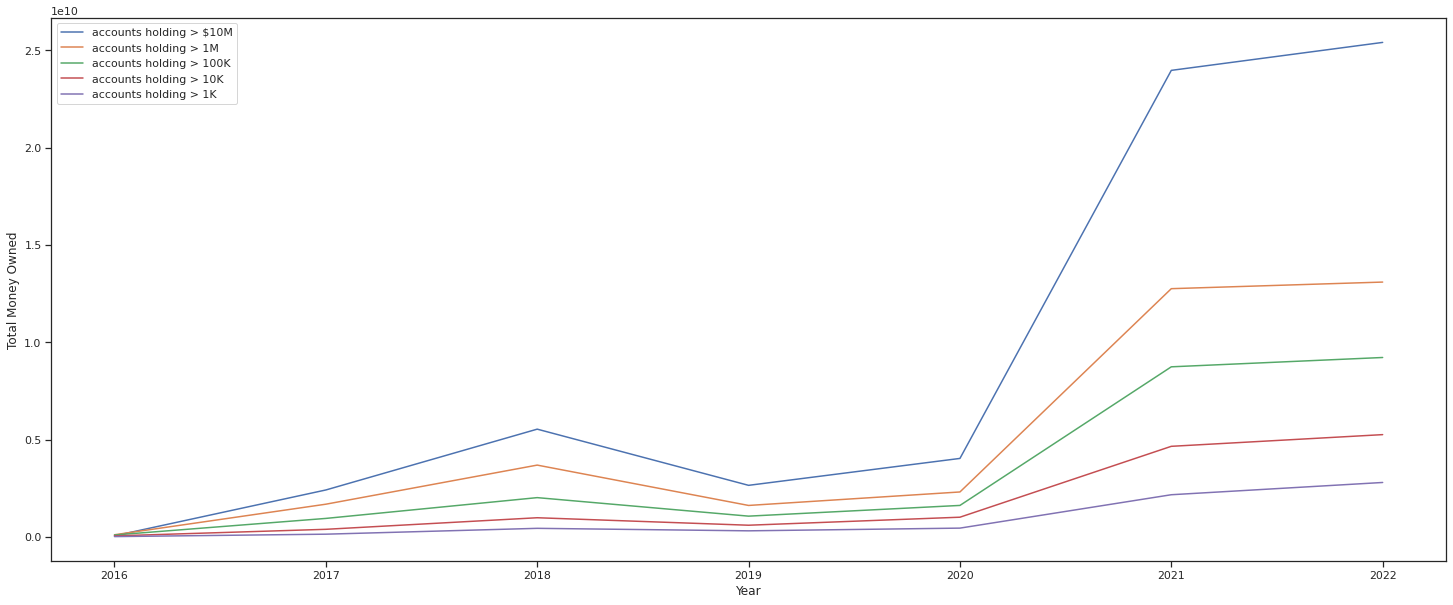

In [ ]:
# Amount Owned By Addresses At Each Wealth Level in Ethereum Over Time
plt.figure(figsize=(25,10))
line_plot = sns.lineplot(x='year', y='10msum', data=eth_wealth_df, ci=None, palette = 'bright', label="accounts holding > $10M")
line_plot = sns.lineplot(x='year', y='1msum', data=eth_wealth_df, ci=None, palette = 'bright', label="accounts holding > 1M")
line_plot = sns.lineplot(x='year', y='100ksum', data=eth_wealth_df, ci=None, palette = 'bright', label='accounts holding > 100K')
line_plot = sns.lineplot(x='year', y='10ksum', data=eth_wealth_df, ci=None, palette = 'bright', label='accounts holding > 10K')
line_plot = sns.lineplot(x='year', y='1ksum', data=eth_wealth_df, ci=None, palette = 'bright', label='accounts holding > 1K')
plt.xlabel("Year")
plt.ylabel("Total Money Owned")

Ethereum shows an even wider gap that is being generated since 2020, where the wealthiest of the wallet owners account for over quadruple the amount owned by the bottom threshhold of accounts

The two figures above show that the wealth inequality in Bitcoin and Ethereum skyrocketed in 2020. Interestingly, while the amount of weath that Bitcoin addresses with over 1M USD and over 10MUSD went up at the same rate, Ethereum accounts with over 10M USD gained got significantly more wealth than accounts with 1M USD. As a result, we can conclude that while ~1% of Bitcoin and Ethereum addresses own the majority of the wealth, there is an even smaller percentage of Ethereum accounts, those that have over 10M USD, that are significantly wealthier than everyone else. 

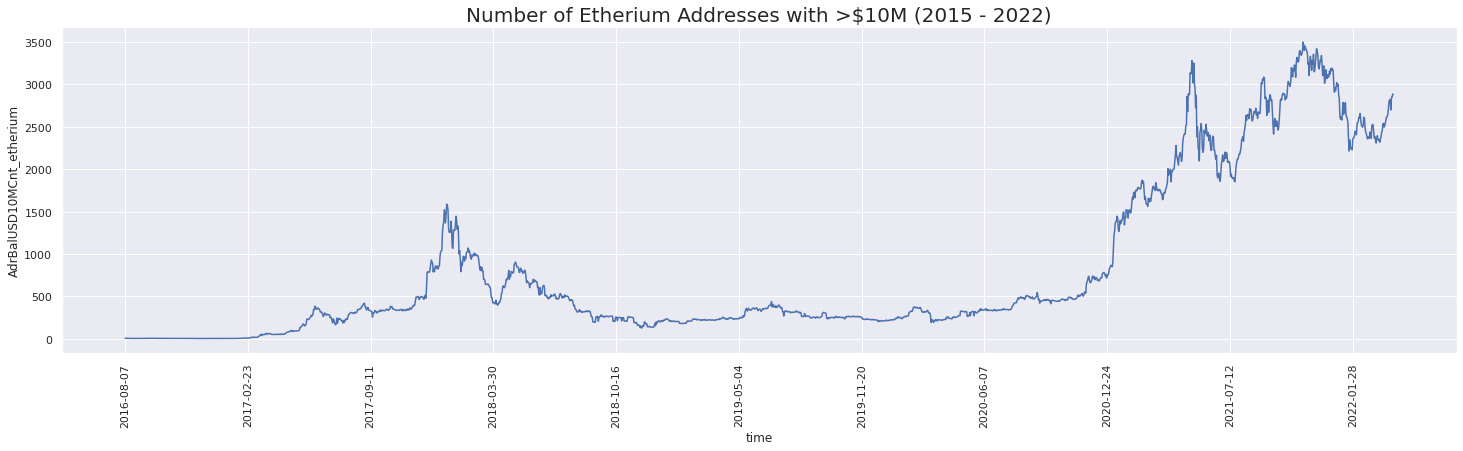

In [ ]:
#Number of people with 1 million dollars
am = etherium_df[['time', 'AdrBalUSD10MCnt_etherium']]
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='time', y='AdrBalUSD10MCnt_etherium', data=am, ci=None, palette = 'flare_r')
line_plot.set_title('Number of Etherium Addresses with >$10M (2015 - 2022)', fontsize=20)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, ])
for item in line_plot.get_xticklabels():
    item.set_rotation(90)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


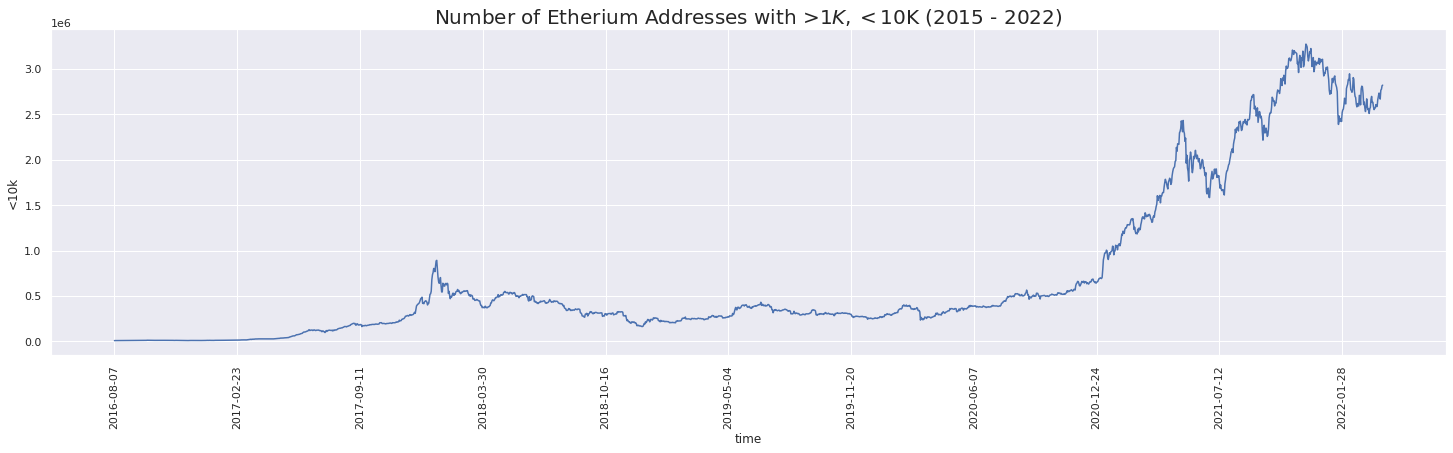

In [ ]:
#Number of Accounts With >$1K in Etherium Over Time
am = etherium_df[['time', 'AdrBalUSD1KCnt_etherium', 'AdrBalUSD10KCnt_etherium']]
am['<10k'] = am['AdrBalUSD1KCnt_etherium'] - am['AdrBalUSD10KCnt_etherium']
sns.set(font_scale = 1)
plt.figure(figsize=(25,6))
line_plot = sns.lineplot(x='time', y='<10k', data=am, ci=None, palette = 'flare_r')
line_plot.set_title('Number of Etherium Addresses with >$1K, < $10K (2015 - 2022)', fontsize=20)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, ])
for item in line_plot.get_xticklabels():
    item.set_rotation(90)

## Data Modeling

For data modeling, we will hone in on one popular cryptocurrency among our datasets: Ethereum. This cryptocurreny has served as a well-known name for the blockchain world, so our team in this section trains a model that is able to predict the (ranged) amount of individuals with \$1 million to \$10 million dollars USD given feature parameters such as fees, number of daily transactions, and mean sum of USD transfered each day. By modeling the amount of individuals who have \$1 million to \$10 million USD of Etherium currency, we aim to represent the individuals who simulate the top 5% (in terms of wealth) in the Etherium blockchain. In this manner, when given specific parameters, our model can predict how much wealth inequity will result from those parameters. An increased amount of individuals who have \$1 million to \$10 million USD of Etherium currency correlates to increased wealth inequality (as currency on Etherium is being concentrated among the rich). Contrarily, a decreased amount of individuals who have \$1 million to \$10 million USD of Etherium currency correlates to increased wealth equality. 

Our final model will be a **Random Forest classifier model**, which will take features such as average daily Etherium fees and output the number of users with \$1 million to \$10 million dollars USD.

The purpose of the first portion is to clearly model the correlation between select features of the Etherium blockchain. We hence gain insight into which features will be most pivotal in our data modeling. In our data modeling pipeline, we will conduct Pricipal Component Analysis which chooses the select features that have the greatest correlations with the amount of individuals who have \$1 million to \$10 million USD of Etherium currency; however, this PCA does not highlight which features are chosen. Through the correlation matrix and linear regression visualizations, we hope to gain insight into some of the major features that will likely be chosen to be kept by PCA.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

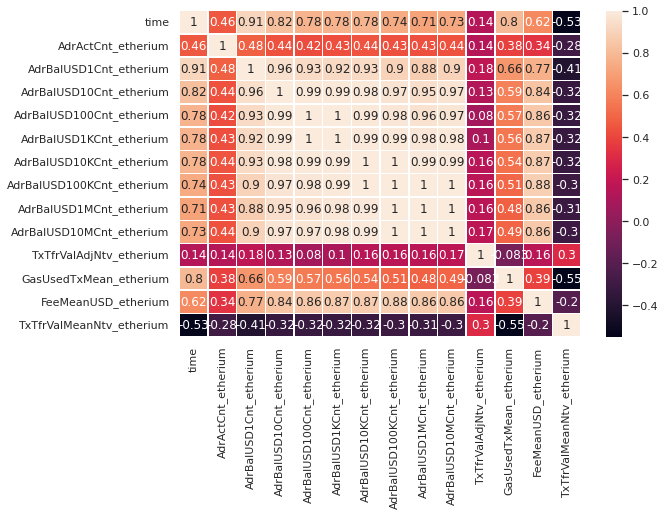

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Extracting Appropriate Columns
etherium_model_df = etherium_df[['time', 'AdrActCnt_etherium','AdrBalUSD1Cnt_etherium', 'AdrBalUSD10Cnt_etherium', 'AdrBalUSD100Cnt_etherium', 'AdrBalUSD1KCnt_etherium', 'AdrBalUSD10KCnt_etherium', 'AdrBalUSD100KCnt_etherium','AdrBalUSD1MCnt_etherium', 'AdrBalUSD10MCnt_etherium','TxTfrValAdjNtv_etherium', 'GasUsedTxMean_etherium', 'FeeMeanUSD_etherium', 'TxTfrValMeanNtv_etherium']]

# Calcululating Number of Users
etherium_model_df['AdrBalUSD10MCnt_etherium'] = etherium_model_df['AdrBalUSD10MCnt_etherium']
etherium_model_df['AdrBalUSD1MCnt_etherium'] = etherium_model_df['AdrBalUSD1MCnt_etherium'] - etherium_model_df['AdrBalUSD10MCnt_etherium']
etherium_model_df['AdrBalUSD100KCnt_etherium'] = etherium_model_df['AdrBalUSD100KCnt_etherium'] - etherium_model_df['AdrBalUSD1MCnt_etherium']
etherium_model_df['AdrBalUSD10KCnt_etherium'] = etherium_model_df['AdrBalUSD10KCnt_etherium'] - etherium_model_df['AdrBalUSD100KCnt_etherium']
etherium_model_df['AdrBalUSD1KCnt_etherium'] = etherium_model_df['AdrBalUSD1KCnt_etherium'] - etherium_model_df['AdrBalUSD10KCnt_etherium']
etherium_model_df['AdrBalUSD100Cnt_etherium'] = etherium_model_df['AdrBalUSD100Cnt_etherium'] - etherium_model_df['AdrBalUSD1KCnt_etherium']
etherium_model_df['AdrBalUSD10Cnt_etherium'] = etherium_model_df['AdrBalUSD10Cnt_etherium'] - etherium_model_df['AdrBalUSD100Cnt_etherium']
etherium_model_df['AdrBalUSD1Cnt_etherium'] = etherium_model_df['AdrBalUSD1Cnt_etherium'] - etherium_model_df['AdrBalUSD10Cnt_etherium']

# One-Hot encoding for modeling
le = LabelEncoder()
integer_dates = le.fit_transform(etherium_model_df['time'].astype(str))
etherium_model_df['time'] = integer_dates
etherium_model_df = etherium_model_df.dropna()

corr_mat = etherium_model_df.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr_mat,annot=True, linewidths=.5, ax=ax)

Note that in our above correlation matrix, AdrBalUSDxCnt_etherium means the amount of individuals with greater or equal to x dollars USD worth of Etherium in their account. TxTfrValAdjUSD is the USD value of the sum of native units transferred that day removing noise and certain artifacts. GasUsedTxMean is the average quantity to gas used daily. FeeMeanUSD is the average amount of daily fees on the Etherium blockchain. 

The correlation matrix partially validates our original hypothesis that the amount of individuals who are in the bottom 5% of wealth in terms dollars of USD worth of Etherium are positively correlated to the amount of individuals in the top 5% of wealth. It also supports the fact that the wealth distribution is has a high positive correlation with time (the more time that elapses, the more the wealth gap increases with increased amounts of individuals with both high and low concentrations of wealth. 

The following heap map that is visualized compares how time and the amount of individuals who have between \$10 million to \$100 million USD worth of Etherium are correlated. The heat maps time x axis is labeled by days since Etherium first began its operations. The heat map identifies a lower initial concentration of individuals in this demographic during the beginning of the Etherium blockchian (shown in the srong oranges when time is between 0 and 1500 days). The light pink near the later dates (around 2000 days) shows a drastic increase in amount of individuals with \$10 million to \$100 million USD worth of Etherium.

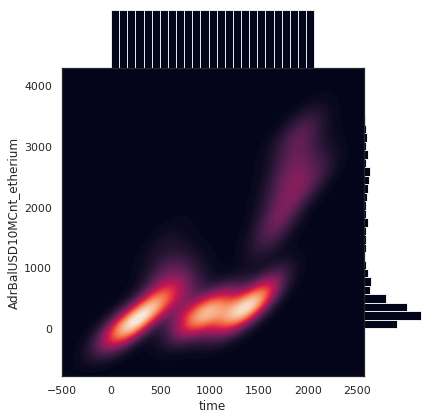

In [ ]:
g = sns.JointGrid(data=etherium_model_df, x="time", y="AdrBalUSD10MCnt_etherium", space=0)
sns.set_theme(style="white")
g.plot_joint(sns.kdeplot,
             fill=True,thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)

We create a few linear regression graphs to demonstrate the strong (positive or negative) correlations between Time vs Number of Ethereum Transactions, Number of people who own \$10 million to \$100 million USD worth of Etherium, and Average Fees. Note the Dates are one-hot encoded into integers, with the integer corresponding the the number day since the first date entry in our dataset (August 2016). For example, Date of 200 stands for 200 days since August 2016.

The resulting graphs show that each of the graphed features are positively correlated with time elased, validating our claim about how time has a direct correlation to wealth inequality and popularity of a given cryptocurrency. 

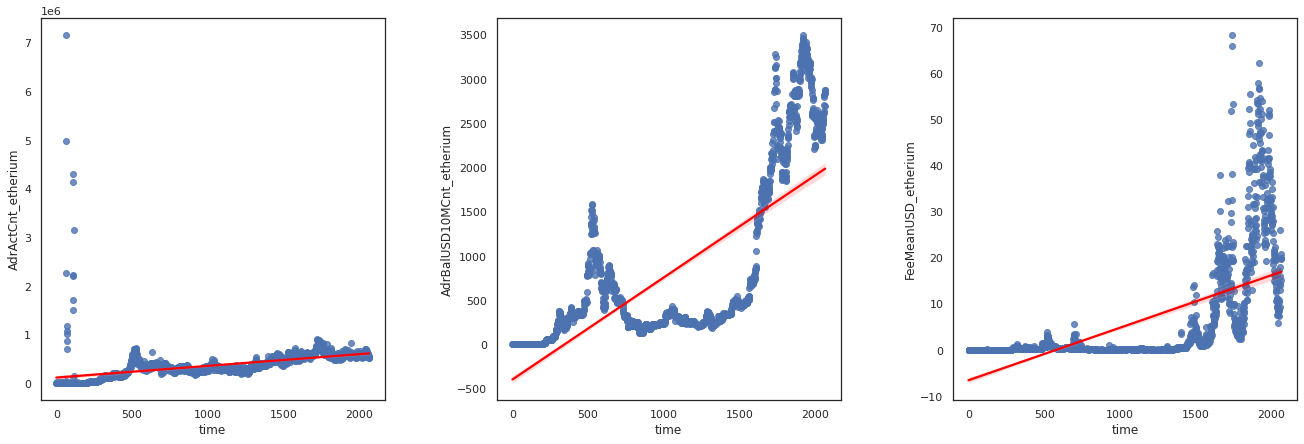

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 6))
fig.tight_layout()
plt.subplots_adjust(right = 2)
sns.regplot(x="time", y="AdrActCnt_etherium", data=etherium_model_df, line_kws={'color':'red'}, ax = axs[0])
sns.regplot(x="time", y="AdrBalUSD10MCnt_etherium", data=etherium_model_df, line_kws={'color':'red'}, ax = axs[1])
sns.regplot(x="time", y="FeeMeanUSD_etherium", data=etherium_model_df, line_kws={'color':'red'}, ax = axs[2])

We will now begin our modeling of the Etherium dataset. We will model how wealth inequality (people who have greater than 1 million and less than 10 million USD worth of Etherium currency). Our hypothesis is that Etherium has an positive relationship between date and concentration of overall distribution of wealth by the minority. This would entail that Etherium displays a parallel relationship with today's USD currency, which has shown to be a source of immense wealth inequality. [Below is a graph](https://www.theguardian.com/business/2014/nov/13/us-wealth-inequality-top-01-worth-as-much-as-the-bottom-90) from The Guardian about wealth inequality in the United States, which informs our data modeling to see whether features such as fees and date affect the concentration of wealth at the top (the number of people who have greater than 1 million and less than 10 million USD worth of Etherium currency) for decentralized curreencies such as Etherium. 

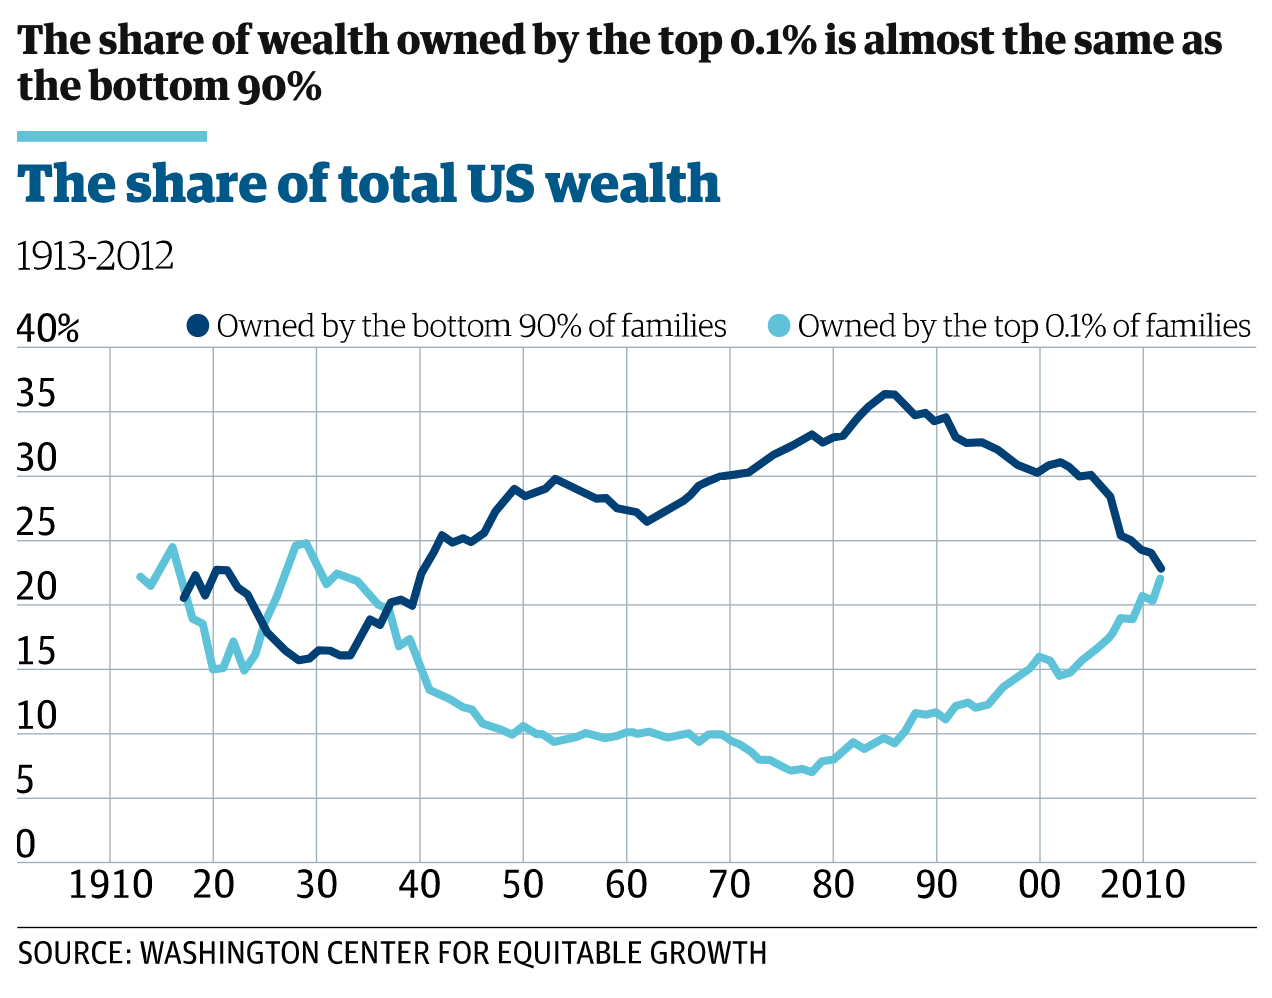

In [ ]:
etherium_final_model_df = etherium_df.copy()

# Re-evaluate columns and one-hot encode time column
etherium_final_model_df['time'] = etherium_model_df['time']
etherium_final_model_df['AdrBalUSD10MCnt_etherium'] = etherium_model_df['AdrBalUSD10MCnt_etherium']
etherium_final_model_df['AdrBalUSD1MCnt_etherium'] = etherium_model_df['AdrBalUSD1MCnt_etherium'] 
etherium_final_model_df['AdrBalUSD100KCnt_etherium'] = etherium_model_df['AdrBalUSD100KCnt_etherium']
etherium_final_model_df['AdrBalUSD10KCnt_etherium'] = etherium_model_df['AdrBalUSD10KCnt_etherium'] 
etherium_final_model_df['AdrBalUSD1KCnt_etherium'] = etherium_model_df['AdrBalUSD1KCnt_etherium'] 
etherium_final_model_df['AdrBalUSD100Cnt_etherium'] = etherium_model_df['AdrBalUSD100Cnt_etherium'] 
etherium_final_model_df['AdrBalUSD10Cnt_etherium'] = etherium_model_df['AdrBalUSD10Cnt_etherium'] 
etherium_final_model_df['AdrBalUSD1Cnt_etherium'] = etherium_model_df['AdrBalUSD1Cnt_etherium'] 

etherium_final_model_df

,time,AdrActCnt_etherium,AdrBal1in100KCnt_etherium,AdrBal1in100MCnt_etherium,AdrBal1in10BCnt_etherium,AdrBal1in10KCnt_etherium,AdrBal1in10MCnt_etherium,AdrBal1in1BCnt_etherium,AdrBal1in1KCnt_etherium,AdrBal1in1MCnt_etherium,...,TxTfrCnt_etherium,TxTfrValAdjNtv_etherium,TxTfrValAdjUSD_etherium,TxTfrValMeanNtv_etherium,TxTfrValMeanUSD_etherium,TxTfrValMedNtv_etherium,TxTfrValMedUSD_etherium,VelCur1yr_etherium,VtyDayRet180d_etherium,VtyDayRet30d_etherium
374,0,20085.0,5715.0,63586.0,142351.0,1119.0,34264.0,89763.0,112.0,15656.0,...,51113.0,1.975374e+06,2.177514e+07,62.183892,685.471741,1.001421,11.038961,7.024621,0.084586,0.091806
375,1,20439.0,5738.0,63125.0,142645.0,1118.0,34108.0,89944.0,111.0,15683.0,...,75328.0,1.996075e+06,2.257538e+07,39.049717,441.647804,0.147550,1.668772,7.043333,0.084186,0.091690
376,2,22799.0,5761.0,63473.0,143324.0,1132.0,34243.0,89909.0,108.0,15757.0,...,55293.0,3.565106e+06,4.387603e+07,100.900193,1241.786121,1.003216,12.346657,7.087723,0.081587,0.092947
377,3,21183.0,5817.0,63917.0,143945.0,1146.0,34615.0,90336.0,112.0,15933.0,...,52842.0,4.543117e+06,5.494717e+07,132.054508,1597.146110,1.003051,12.131497,7.151241,0.081409,0.092723
378,4,22502.0,5842.0,63406.0,144707.0,1163.0,34451.0,90800.0,113.0,15977.0,...,55715.0,3.588709e+06,4.200713e+07,105.464380,1234.498595,1.001092,11.718140,7.210277,0.081366,0.092968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,2062,588466.0,5504.0,1209766.0,20773087.0,1038.0,245442.0,5966639.0,120.0,36475.0,...,949655.0,2.615690e+06,8.584139e+09,3.649993,11978.502974,0.080000,262.543001,14.621032,0.039125,0.032171
2437,2063,565448.0,5507.0,1211110.0,20796685.0,1036.0,245473.0,5970072.0,120.0,36474.0,...,947283.0,2.283146e+06,7.868907e+09,3.079442,10613.358899,0.098750,340.343834,14.601765,0.039292,0.033182
2438,2064,540620.0,5511.0,1212713.0,20820014.0,1037.0,245506.0,5978192.0,119.0,36469.0,...,946755.0,1.570187e+06,5.420231e+09,2.048133,7070.085543,0.081597,281.671055,14.522577,0.039287,0.032049
2439,2065,533295.0,5516.0,1213999.0,20835649.0,1036.0,245540.0,5986302.0,119.0,36465.0,...,1030407.0,1.116917e+06,3.933259e+09,1.430046,5035.954895,0.079787,280.971919,14.458554,0.039217,0.027590


We split the data on number of users with greater than 1 million USD worth of Ethereum (and less than 10 million) into 8 evenly sized bins. The following 8 ranges of floats represent the 8 ranges of amount of individuals with that much range of money. Note the float values are in context of millions of USD worth of Ethereum. The below are the ranges:

(76.999, 481.5] -- labeled 0, (481.5, 1439.5] -- labeled 1, (1439.5, 1826.75] -- labeled 2, (1826.75, 2269.0] -- labeled 3 (2269.0, 3051.25] -- labeled 4, (3051.25, 5541.0] -- labeled 5, (5541.0, 11961.25] -- labeled 6, (11961.25, 19705.0] -- labeled 7.

We will train our Random Forest Classifer to accurately predict which of these labels is appropriate (guess range of individuals with 1 million USD worth of Ethereum (and less than 10 million) given the input features.

In [ ]:
# Assign distribution as feature label on dataframe
distribution_label = pd.qcut(etherium_final_model_df['AdrBalUSD1MCnt_etherium'], 8, retbins = True)
distribution_label

(374         (76.999, 481.5]
 375         (76.999, 481.5]
 376         (76.999, 481.5]
 377         (76.999, 481.5]
 378         (76.999, 481.5]
                ...         
 2436    (11961.25, 19705.0]
 2437    (11961.25, 19705.0]
 2438    (11961.25, 19705.0]
 2439    (11961.25, 19705.0]
 2440    (11961.25, 19705.0]
 Name: AdrBalUSD1MCnt_etherium, Length: 2067, dtype: category
 Categories (8, interval[float64, right]): [(76.999, 481.5] < (481.5, 1439.5] < (1439.5, 1826.75] <
                                            (1826.75, 2269.0] < (2269.0, 3051.25] < (3051.25, 5541.0] <
                                            (5541.0, 11961.25] < (11961.25, 19705.0]],
 array([   77.  ,   481.5 ,  1439.5 ,  1826.75,  2269.  ,  3051.25,
         5541.  , 11961.25, 19705.  ]))

In [ ]:
# Full (cleaned) dataframe we will be modeling
etherium_final_model_df['y_label'] = pd.qcut(etherium_final_model_df['AdrBalUSD1MCnt_etherium'], 8 ,labels =  [0, 1, 2, 3, 4, 5, 6, 7])
etherium_final_model_df

,time,AdrActCnt_etherium,AdrBal1in100KCnt_etherium,AdrBal1in100MCnt_etherium,AdrBal1in10BCnt_etherium,AdrBal1in10KCnt_etherium,AdrBal1in10MCnt_etherium,AdrBal1in1BCnt_etherium,AdrBal1in1KCnt_etherium,AdrBal1in1MCnt_etherium,...,TxTfrValAdjNtv_etherium,TxTfrValAdjUSD_etherium,TxTfrValMeanNtv_etherium,TxTfrValMeanUSD_etherium,TxTfrValMedNtv_etherium,TxTfrValMedUSD_etherium,VelCur1yr_etherium,VtyDayRet180d_etherium,VtyDayRet30d_etherium,y_label
374,0,20085.0,5715.0,63586.0,142351.0,1119.0,34264.0,89763.0,112.0,15656.0,...,1.975374e+06,2.177514e+07,62.183892,685.471741,1.001421,11.038961,7.024621,0.084586,0.091806,0
375,1,20439.0,5738.0,63125.0,142645.0,1118.0,34108.0,89944.0,111.0,15683.0,...,1.996075e+06,2.257538e+07,39.049717,441.647804,0.147550,1.668772,7.043333,0.084186,0.091690,0
376,2,22799.0,5761.0,63473.0,143324.0,1132.0,34243.0,89909.0,108.0,15757.0,...,3.565106e+06,4.387603e+07,100.900193,1241.786121,1.003216,12.346657,7.087723,0.081587,0.092947,0
377,3,21183.0,5817.0,63917.0,143945.0,1146.0,34615.0,90336.0,112.0,15933.0,...,4.543117e+06,5.494717e+07,132.054508,1597.146110,1.003051,12.131497,7.151241,0.081409,0.092723,0
378,4,22502.0,5842.0,63406.0,144707.0,1163.0,34451.0,90800.0,113.0,15977.0,...,3.588709e+06,4.200713e+07,105.464380,1234.498595,1.001092,11.718140,7.210277,0.081366,0.092968,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,2062,588466.0,5504.0,1209766.0,20773087.0,1038.0,245442.0,5966639.0,120.0,36475.0,...,2.615690e+06,8.584139e+09,3.649993,11978.502974,0.080000,262.543001,14.621032,0.039125,0.032171,7
2437,2063,565448.0,5507.0,1211110.0,20796685.0,1036.0,245473.0,5970072.0,120.0,36474.0,...,2.283146e+06,7.868907e+09,3.079442,10613.358899,0.098750,340.343834,14.601765,0.039292,0.033182,7
2438,2064,540620.0,5511.0,1212713.0,20820014.0,1037.0,245506.0,5978192.0,119.0,36469.0,...,1.570187e+06,5.420231e+09,2.048133,7070.085543,0.081597,281.671055,14.522577,0.039287,0.032049,7
2439,2065,533295.0,5516.0,1213999.0,20835649.0,1036.0,245540.0,5986302.0,119.0,36465.0,...,1.116917e+06,3.933259e+09,1.430046,5035.954895,0.079787,280.971919,14.458554,0.039217,0.027590,7


The below histoplot demonstrates the equal distribution of amount of individuals in each of our 8 buckets/ranges. This equal distribution will allow our model to accurately predict.

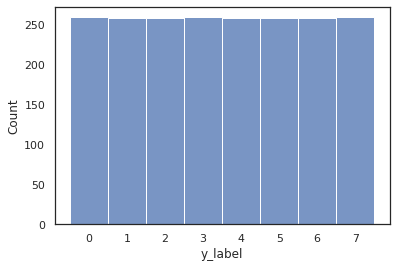

In [ ]:
# Shows how each label is equally as likely to occur in our dataset
sns.histplot(etherium_final_model_df['y_label'])

Below we first conduct Pricipal Component Analysis in order to lower the dimentionality of our dataset's features. We graph the varience ratio of our dataset across 25 features, finding a suitable amount of features to keep in ordere to boost our model's accuracy.

In [ ]:
labels = etherium_final_model_df['y_label']
features = etherium_final_model_df.drop(columns=['y_label'])

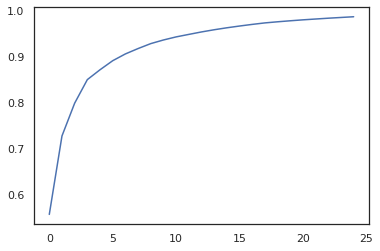

In [ ]:
# Running PCA to find the optimal # of components

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np 

X = StandardScaler().fit_transform(features)
pca = PCA(n_components=25)
X2 = pca.fit_transform(X)

# Plot explained variance ratio

np.set_printoptions(suppress=True)
features_vs_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(features_vs_variance)

We see that ~9 components can explain over 90% the variance. We will use these 9 components to predict the number of users with greater than 1 million USD worth of Ethereum (and less than 10 million).

We also perform a Grid Search in order to find the optimal hyperparameters (max random tree depth for our forest model, as well as number of estimators) for our Random Forest Model.

Note that each run of the Random Forest Model outputs different optimal hyperparameters. At the time of our running, the optimal parameters was 64 estimators and max depth of 70.

In [ ]:
# Perform Principal Component Analysis

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
pca = PCA(n_components=9)
scale = StandardScaler()
x_train_pca = scale.fit_transform(x_train)
x_test_pca = scale.transform(x_test)
pca.fit(x_train_pca)
x_train_pca = pca.transform(x_train_pca)
x_test_pca = pca.transform(x_test_pca)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Grid Search for Best Hyperparameters
def print_optimal_params(res):
    print('Optimal Parameters: {}\n'.format(res.best_params_))

gridParameters = {'max_depth': [10, 20, 30, 40, 50, 60, 70], 'n_estimators': [16, 32, 64, 128, 256]}
randoForest = RandomForestClassifier()
randoForest_gridSearch = GridSearchCV(estimator = randoForest, param_grid = gridParameters, 
                          cv = 3, n_jobs = -1, verbose = 2)

randoForest_gridSearch.fit(x_train_pca, y_train)
print_optimal_params(randoForest_gridSearch)

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Optimal Parameters: {'max_depth': 20, 'n_estimators': 128}



In [ ]:
# Test accuracy of Random Forest Model
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=64, max_depth = 70)
classifier.fit(x_train_pca, y_train)

# RANDOM FOREST CLASSIFICATION DESCRIPTION
pred = classifier.predict(x_test_pca)

accuracyTest = accuracy_score(y_test, pred)
print('Random Forest Classifier Accuracy: ' + str(accuracyTest))

Random Forest Classifier Accuracy: 0.9251207729468599


Our Random Forest Classifier accuracy is over 93%, which ultimately means that our model is able to correctly predict that amount (ranged) of individuals with 1 million USD worth of Ethereum (and less than 10 million). This demonstrates that there is high correlation between our input features and our final label of concentrated wealth. 

This final modeling validates our original hypothesis that there is a direct positive correlation between features like dates, individuals with lower concentrations of Ethereum, and fees with the final label of higher concentrations of wealth. Our original hypothesis was that wealth inequality was directly correlated with dates elapsed, among other features, and as our model is able to correctly predict the individuals with higher concentrations of wealth with 93% accuracy, we have hence proven our claim.